In [67]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import layers, models, optimizers


In [68]:
file_path = "vibration_raw_data_all.csv"
chunksize = 1_000_000
chunks = []

float_cols = ["xs","ys","zs","xd","yd","zd","xa","ya","za"]

for chunk in pd.read_csv(file_path, chunksize=chunksize):
    #column name clean
    chunk.columns = chunk.columns.str.strip().str.lower()

    # drop unwanted columns
    chunk = chunk.drop(columns=["temperature", "sent_to_s3"], errors='ignore')

    # drop null and dubplicate data
    chunk = chunk.dropna()
    chunk = chunk.drop_duplicates()

    # convert time format and drop null time
    chunk["timestamp"] = pd.to_datetime(chunk["timestamp"], errors='coerce')
    chunk = chunk.dropna(subset=["timestamp"])

    for col in float_cols:
        chunk[col] = pd.to_numeric(chunk[col], errors='coerce')

    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)
df.head()

timestamp device_id  sensor_id    xs    ys    zs   xd   yd  \
0 2025-08-26 14:06:05.800        L2         22  0.02  0.02  0.02  0.0  0.0   
1 2025-08-26 14:06:05.772        L2         22  0.02  0.02  0.02  0.0  0.0   
2 2025-08-26 14:06:05.765        L2         22  0.02  0.02  0.02  0.0  0.0   
3 2025-08-26 14:06:05.740        L2         22  0.02  0.03  0.02  0.0  0.0   
4 2025-08-26 14:06:05.717        L2         22  0.02  0.03  0.02  0.0  0.0   

    zd   xa   ya   za  
0  0.0  0.0  0.0  7.7  
1  0.0  0.0  0.0  7.7  
2  0.0  0.0  0.0  7.7  
3  0.0  0.0  0.0  7.7  
4  0.0  0.0  0.0  7.7

In [69]:
print(len(df))

10462499


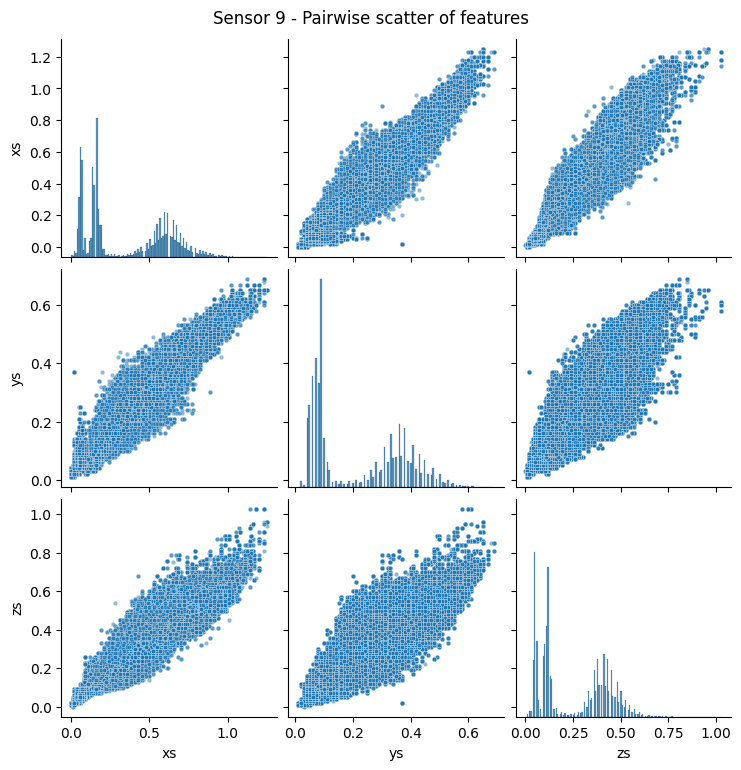

In [70]:
sensor9_df = df[df['sensor_id'] == 9]
sns.pairplot(sensor9_df, vars=['xs','ys','zs'], plot_kws={'s':10, 'alpha':0.5})
plt.suptitle('Sensor 9 - Pairwise scatter of features', y=1.02)
plt.show()

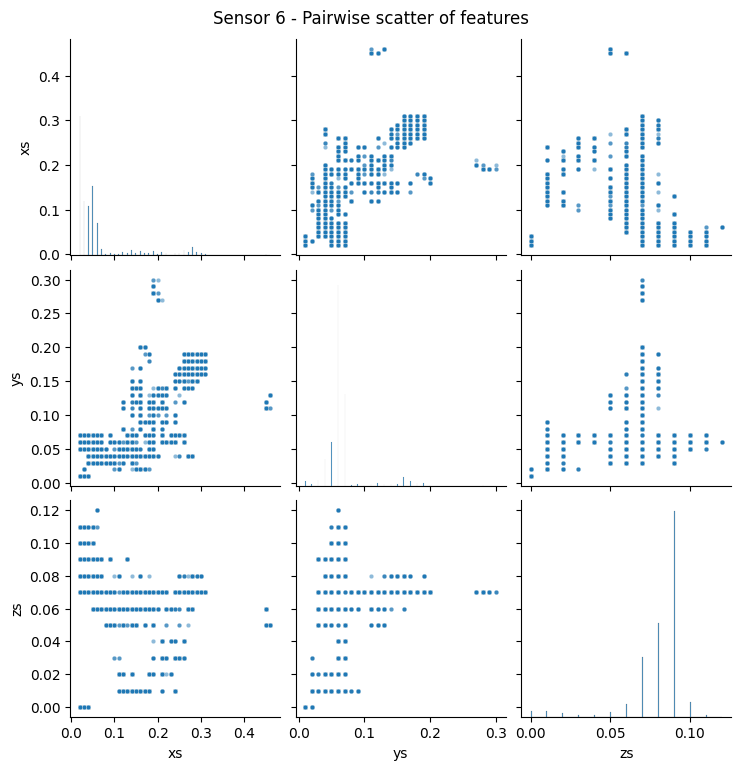

In [71]:
sensor6_df = df[df['sensor_id'] == 6]
sns.pairplot(sensor6_df, vars=['xs','ys','zs'], plot_kws={'s':10, 'alpha':0.5})
plt.suptitle('Sensor 6 - Pairwise scatter of features', y=1.02)
plt.show()

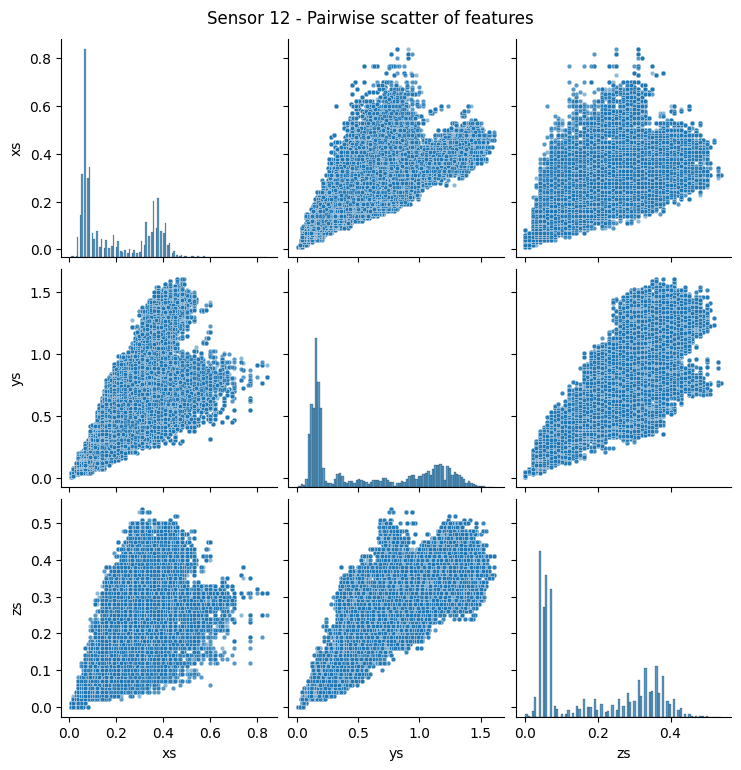

In [72]:
sensor12_df = df[df['sensor_id'] == 12]
sns.pairplot(sensor12_df, vars=['xs','ys','zs'], plot_kws={'s':10, 'alpha':0.5})
plt.suptitle('Sensor 12 - Pairwise scatter of features', y=1.02)
plt.show()

In [73]:
df['gap'] = df.groupby('sensor_id')['timestamp'].diff().dt.total_seconds().fillna(0)

# Set threshold per sensor: median gap * 2, min 0.05s
sensor_thresholds = df.groupby('sensor_id')['gap'].median().fillna(0.05)
sensor_thresholds = sensor_thresholds.apply(lambda x: max(x*2, 0.05))

def assign_burst(sensor_g):
    sid = sensor_g['sensor_id'].iloc[0]
    threshold = sensor_thresholds.get(sid, 0.05)
    return (sensor_g['gap'] > threshold).cumsum()

df['burst_id'] = df.groupby('sensor_id', group_keys=False).apply(assign_burst)
df['burst_id'] = df['sensor_id'].astype(str) + "_" + df['burst_id'].astype(str)


/tmp/ipython-input-1903872078.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['burst_id'] = df.groupby('sensor_id', group_keys=False).apply(assign_burst)


In [74]:
# Define window inside bursts
window_size = 50
data_cols = ['xs','ys','zs']

df['burst_index'] = df.groupby(['sensor_id','burst_id']).cumcount()
df['window_index'] = df['burst_index'] // window_size

In [75]:
data_cols = ['xs','ys','zs']
group_cols = ['sensor_id','burst_id','window_index']

agg_dict = {col: ['mean', 'std', 'max', 'min', 'median'] for col in data_cols}
features_basic = df.groupby(group_cols, sort=False).agg(agg_dict)
features_basic.columns = ['_'.join(col).strip() for col in features_basic.columns.values]
features_basic.reset_index(inplace=True)

# Vectorized RMS, p2p, energy
def calc_rms(x): return np.sqrt(np.mean(x**2))
def calc_p2p(x): return np.max(x) - np.min(x)
def calc_energy(x): return np.sum(x**2) / len(x)

features_extra = df.groupby(group_cols, sort=False)[data_cols].agg([
    calc_rms, calc_p2p, pd.Series.skew, pd.Series.kurt, calc_energy
])
# Rename columns
features_extra.columns = [f"{col[0]}_{col[1]}" for col in features_extra.columns]
features_extra.reset_index(inplace=True)

# Combine basic + extra features
features = features_basic.merge(features_extra, on=group_cols, how='left')

time_df = df.groupby(group_cols)['timestamp'].agg(['min','max']).reset_index()
time_df.rename(columns={'min':'window_start', 'max':'window_end'}, inplace=True)
features = features.merge(time_df, on=group_cols, how='left')

print("Number of feature rows:", len(features))
feature_cols = [c for c in features.columns if c not in group_cols + ['timestamp','window_start','window_end']]
print("Feature columns:", feature_cols)

Number of feature rows: 209266
Feature columns: ['xs_mean', 'xs_std', 'xs_max', 'xs_min', 'xs_median', 'ys_mean', 'ys_std', 'ys_max', 'ys_min', 'ys_median', 'zs_mean', 'zs_std', 'zs_max', 'zs_min', 'zs_median', 'xs_calc_rms', 'xs_calc_p2p', 'xs_skew', 'xs_kurt', 'xs_calc_energy', 'ys_calc_rms', 'ys_calc_p2p', 'ys_skew', 'ys_kurt', 'ys_calc_energy', 'zs_calc_rms', 'zs_calc_p2p', 'zs_skew', 'zs_kurt', 'zs_calc_energy']


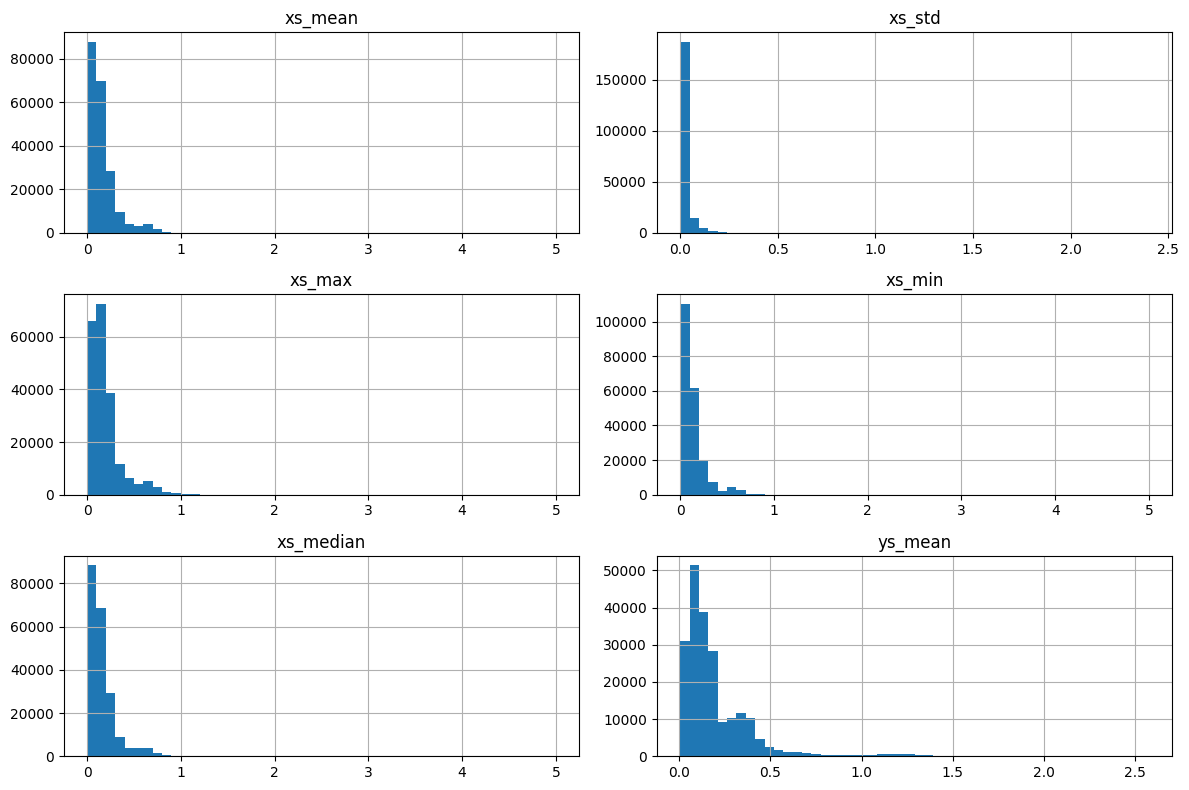

In [76]:
feature_cols = [c for c in features.columns if c not in group_cols + ['timestamp','window_start','window_end']]

# Plot histograms for first 6 features
features[feature_cols[:6]].hist(bins=50, figsize=(12,8))
plt.tight_layout()
plt.show()



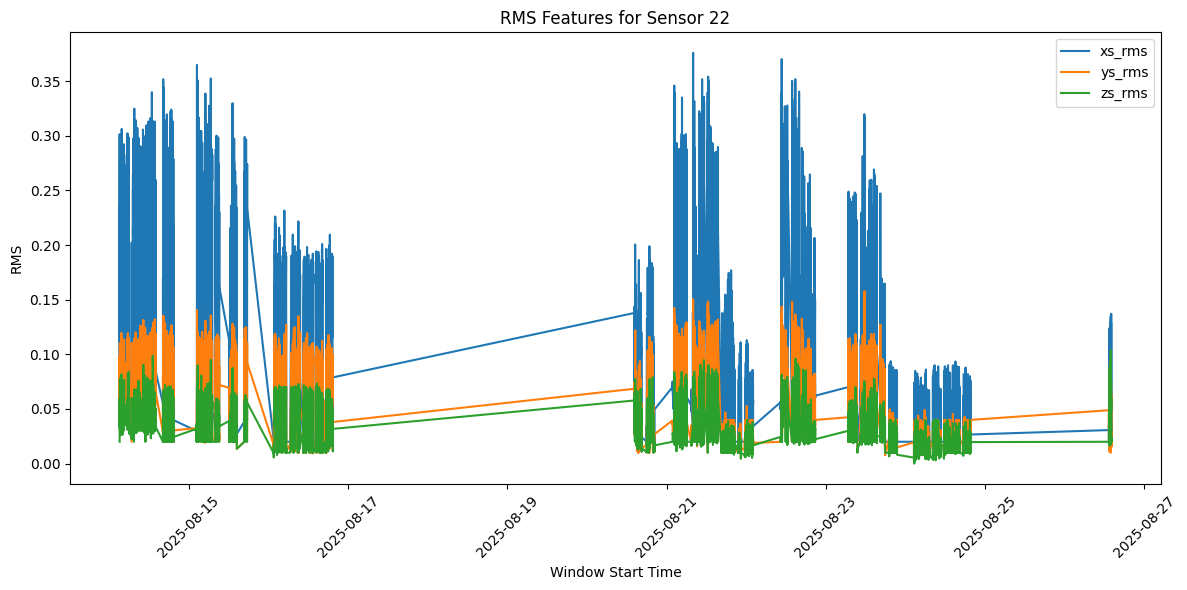

In [77]:
sensor_id = features['sensor_id'].iloc[0]
mask = features['sensor_id'] == sensor_id

plt.figure(figsize=(12,6))
plt.plot(features.loc[mask, 'window_start'], features.loc[mask, 'xs_calc_rms'], label="xs_rms")
plt.plot(features.loc[mask, 'window_start'], features.loc[mask, 'ys_calc_rms'], label="ys_rms")
plt.plot(features.loc[mask, 'window_start'], features.loc[mask, 'zs_calc_rms'], label="zs_rms")
plt.legend()
plt.title(f"RMS Features for Sensor {sensor_id}")
plt.xlabel("Window Start Time")
plt.ylabel("RMS")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


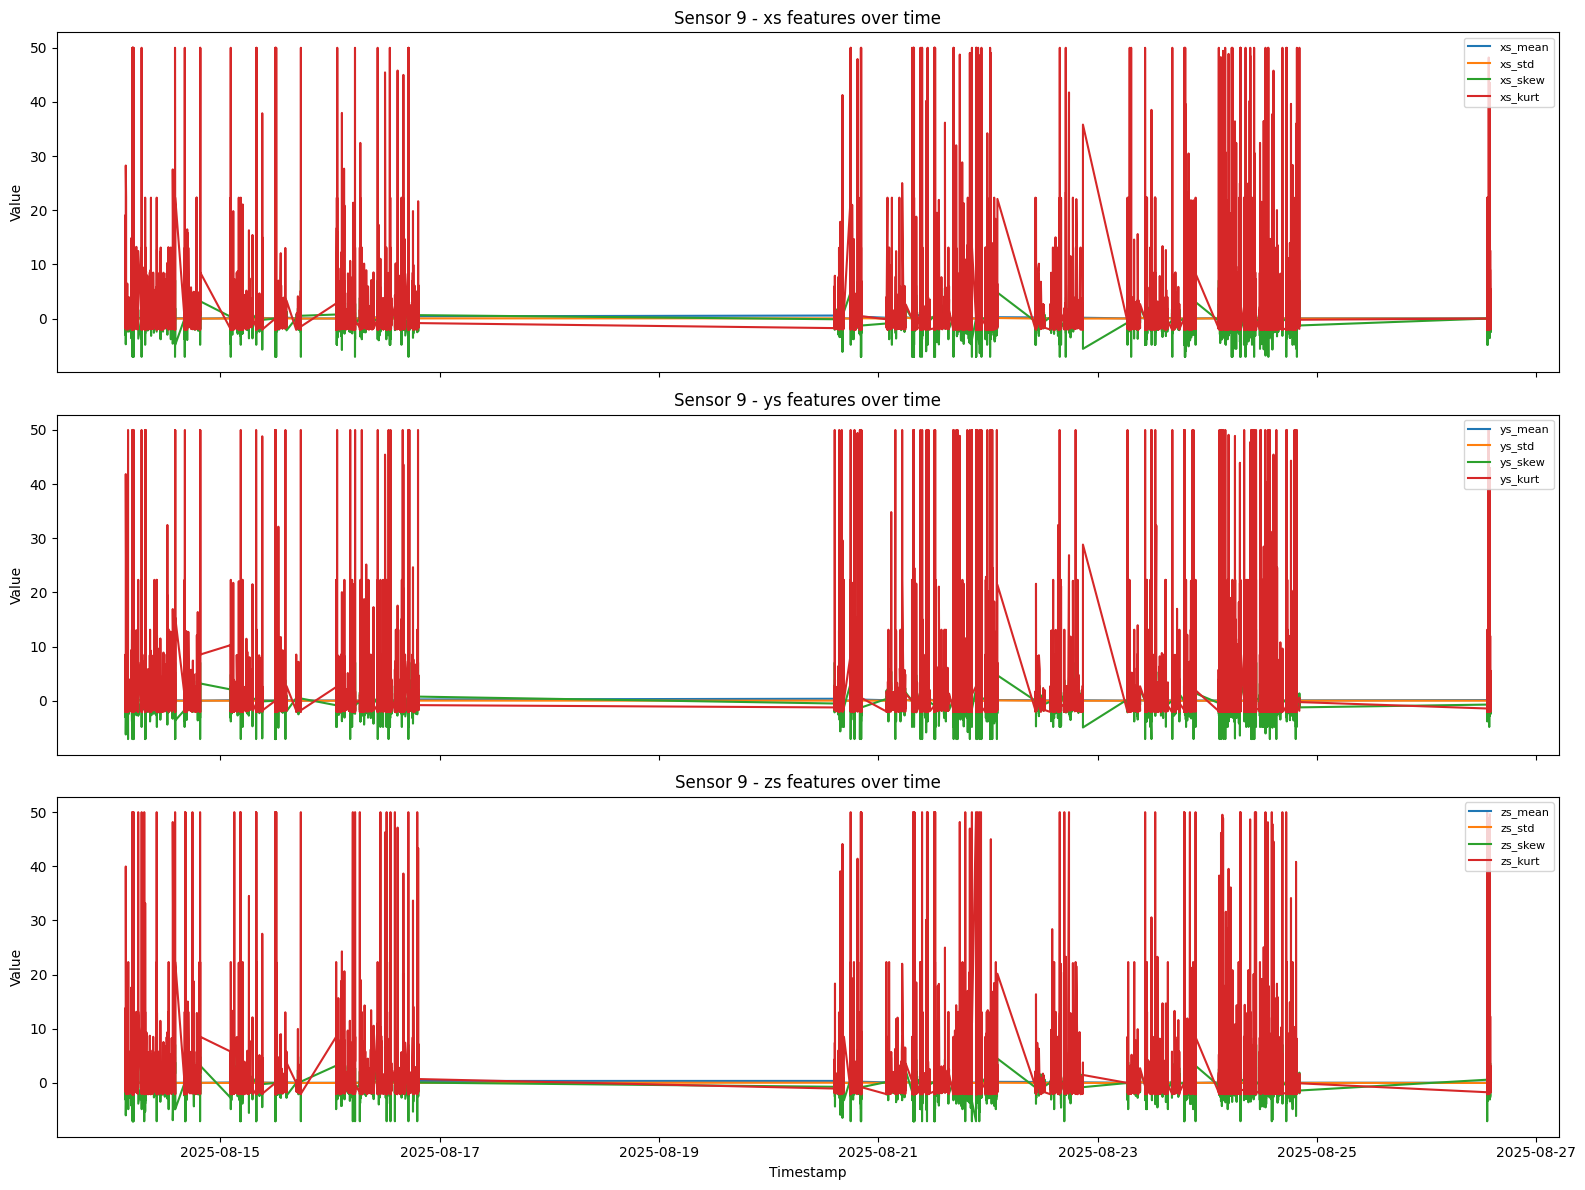

In [78]:
sensor_id = 9
sensor_features = features[features['sensor_id'] == sensor_id].copy()

feature_types = ['mean', 'std', 'rms', 'p2p', 'skew', 'kurt', 'energy']

fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

for i, col in enumerate(['xs', 'ys', 'zs']):
    ax = axes[i]
    for ftype in feature_types:
        feat_col = f'{col}_{ftype}'
        if feat_col in sensor_features.columns:
            ax.plot(sensor_features['window_start'], sensor_features[feat_col], label=feat_col)
    ax.set_title(f'Sensor {sensor_id} - {col} features over time')
    ax.set_ylabel('Value')
    ax.legend(loc='upper right', fontsize=8)

axes[-1].set_xlabel('Timestamp')
plt.tight_layout()
plt.show()


In [79]:
feature_cols = [c for c in features.columns if c not in group_cols + ['timestamp','window_start','window_end']]
features[feature_cols] = features[feature_cols].fillna(0).replace([np.inf,-np.inf],0)


In [80]:
X_all = features[feature_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

input_dim = X_scaled.shape[1]
encoder_input = layers.Input(shape=(input_dim,))
encoded = layers.Dense(64, activation='relu')(encoder_input)
encoded = layers.Dense(32, activation='relu')(encoded)
bottleneck = layers.Dense(16, activation='relu')(encoded)
decoded = layers.Dense(32, activation='relu')(bottleneck)
decoded = layers.Dense(64, activation='relu')(decoded)
decoded = layers.Dense(input_dim, activation='linear')(decoded)

autoencoder = models.Model(encoder_input, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

batch_size = min(256, len(X_scaled))
autoencoder.fit(
    X_scaled, X_scaled,
    epochs=20,
    batch_size=batch_size,
    validation_split=0.2,
    shuffle=True,
    verbose=1
)


X_pred = autoencoder.predict(X_scaled)
features['reconstruction_error'] = np.mean((X_scaled - X_pred)**2, axis=1)

# Sensor-wise threshold
features['anomaly'] = 0
for sensor in features['sensor_id'].unique():
    sensor_mask = features['sensor_id'] == sensor
    sensor_errors = features.loc[sensor_mask, 'reconstruction_error']
    threshold = np.percentile(sensor_errors, 99)
    features.loc[sensor_mask, 'anomaly'] = (sensor_errors > threshold).astype(int)

features['anomaly_score'] = features['reconstruction_error']/features['reconstruction_error'].max()

cols_to_keep = ['sensor_id','window_start','window_end'] + feature_cols + ['reconstruction_error','anomaly','anomaly_score']
features_clean = features[cols_to_keep].copy()
features_clean.reset_index(drop=True, inplace=True)

print("Total anomalies detected:", features_clean['anomaly'].sum())


Epoch 1/20
654/654 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3026 - val_loss: 0.1440
Epoch 2/20
654/654 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0126 - val_loss: 0.1165
Epoch 3/20
654/654 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0076 - val_loss: 0.1040
Epoch 4/20
654/654 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0058 - val_loss: 0.0985
Epoch 5/20
654/654 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0046 - val_loss: 0.0895
Epoch 6/20
654/654 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0039 - val_loss: 0.0869
Epoch 7/20
654/654 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0031 - val_loss: 0.0914
Epoch 8/20
654/654 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0031 - val_loss: 0.0829
Epoch 9/20
654/654 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0029 - val_loss: 0.0804
Epoch 10/20
654/654 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0025 - val_loss: 0.0754
Epoch 11/20
654/654 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0021 - val_loss: 0.0733
Epoch 12/20
654/654 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

In [81]:
# Save Model, Scaler, and Results

autoencoder.save("global_autoencoder_all_sensors.h5")

joblib.dump(scaler, "global_scaler_all_sensors.pkl")

# Save sensor-wise anomaly results
features_clean.to_csv("features_anomaly_results.csv", index=False)
features_clean.head()

sensor_id            window_start              window_end  xs_mean  \
0         22 2025-08-26 14:06:04.419 2025-08-26 14:06:05.800   0.0268   
1         22 2025-08-26 14:06:03.796 2025-08-26 14:06:04.413   0.0204   
2         22 2025-08-26 14:06:03.308 2025-08-26 14:06:03.789   0.0200   
3         22 2025-08-26 14:05:32.932 2025-08-26 14:06:03.301   0.0288   
4          9 2025-08-26 14:05:59.240 2025-08-26 14:06:00.994   0.1074   

     xs_std  xs_max  xs_min  xs_median  ys_mean    ys_std  ...   ys_kurt  \
0  0.004712    0.03    0.02       0.03   0.0220  0.004041  ...  0.407247   
1  0.001979    0.03    0.02       0.02   0.0168  0.004712  ... -1.425366   
2  0.000000    0.02    0.02       0.02   0.0222  0.004185  ... -0.060755   
3  0.003283    0.03    0.02       0.03   0.0254  0.005035  ... -2.056566   
4  0.014115    0.12    0.09       0.12   0.0442  0.005379  ... -1.155677   

   ys_calc_energy  zs_calc_rms  zs_calc_p2p   zs_skew   zs_kurt  \
0        0.000500      0.02000         0.00  0.000000  0.000000   
1        0.000304      0.02000         0.00  0.000000  0.000000   
2        0.000510      0.02000         0.00  0.000000  0.000000   
3        0.000670      0.02000         0.00  0.000000  0.000000   
4        0.001982      0.08951         0.03 -1.368473  2.459296   

   zs_calc_energy  reconstruction_error  anomaly  anomaly_score  
0        0.000400              0.000227        0   1.223254e-06  
1        0.000400              0.000772        0   4.155725e-06  
2        0.000400              0.000133        0   7.155647e-07  
3        0.000400              0.000126        0   6.790465e-07  
4        0.008012              0.000308        0   1.655940e-06  

[5 rows x 36 columns]

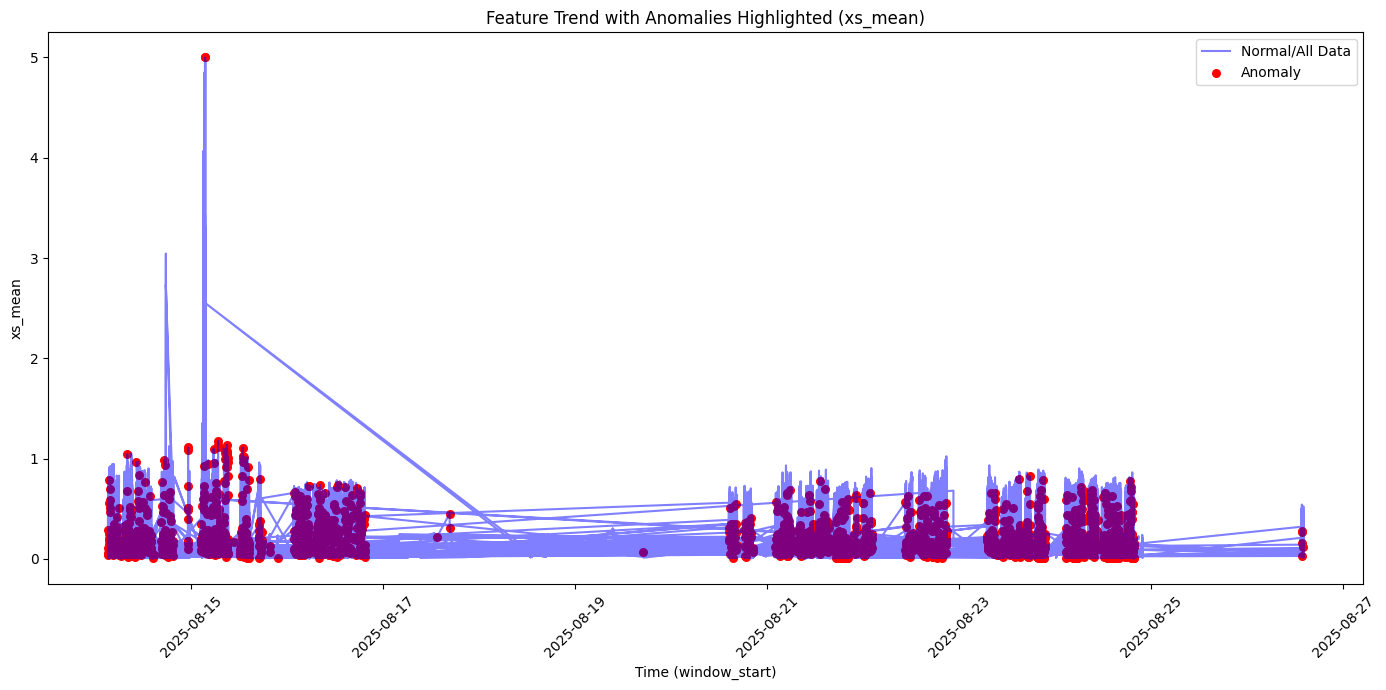

In [84]:
df_plot = features_clean.copy()

# Choose one feature to visualize (e.g., xs_mean)
feature_to_plot = "xs_mean"

plt.figure(figsize=(14, 7))

# Plot all feature values (blue)
plt.plot(
    df_plot['window_start'],
    df_plot[feature_to_plot],
    c='blue',
    alpha=0.5,
    label="Normal/All Data"
)

# Overlay anomalies (red points)
anomalies = df_plot[df_plot['anomaly'] == 1]
plt.scatter(
    anomalies['window_start'],
    anomalies[feature_to_plot],
    c='red',
    s=30,
    label="Anomaly"
)

plt.xlabel("Time (window_start)")
plt.ylabel(f"{feature_to_plot}")
plt.title(f"Feature Trend with Anomalies Highlighted ({feature_to_plot})")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


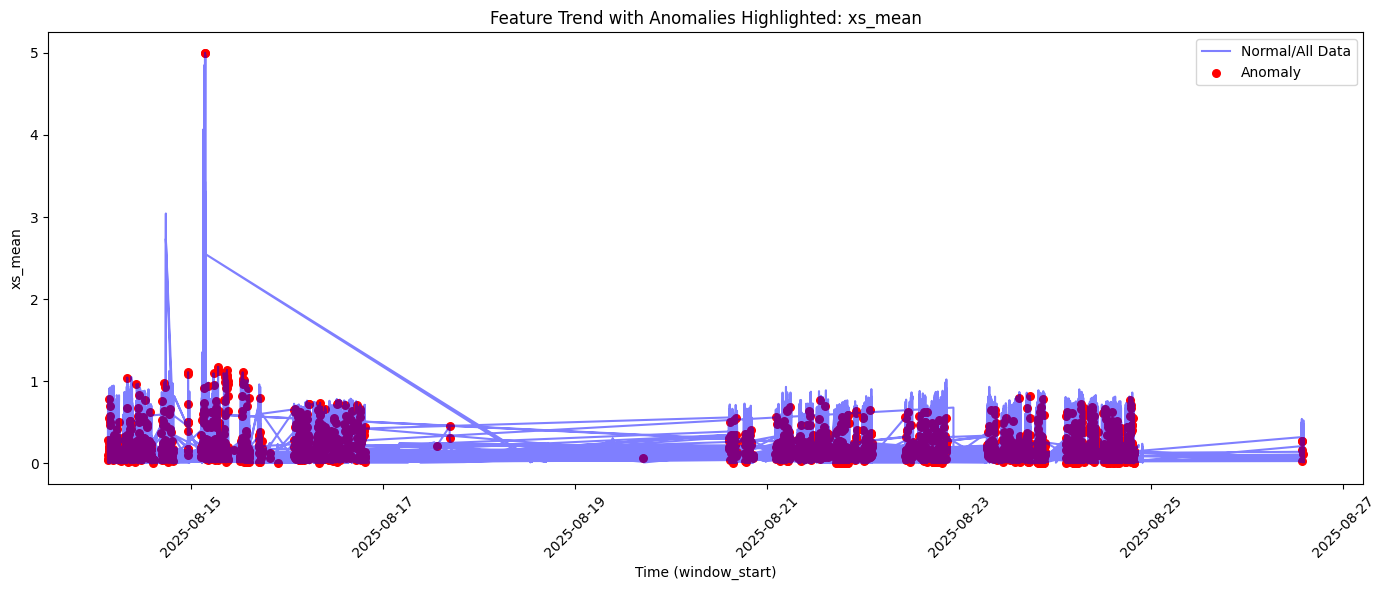

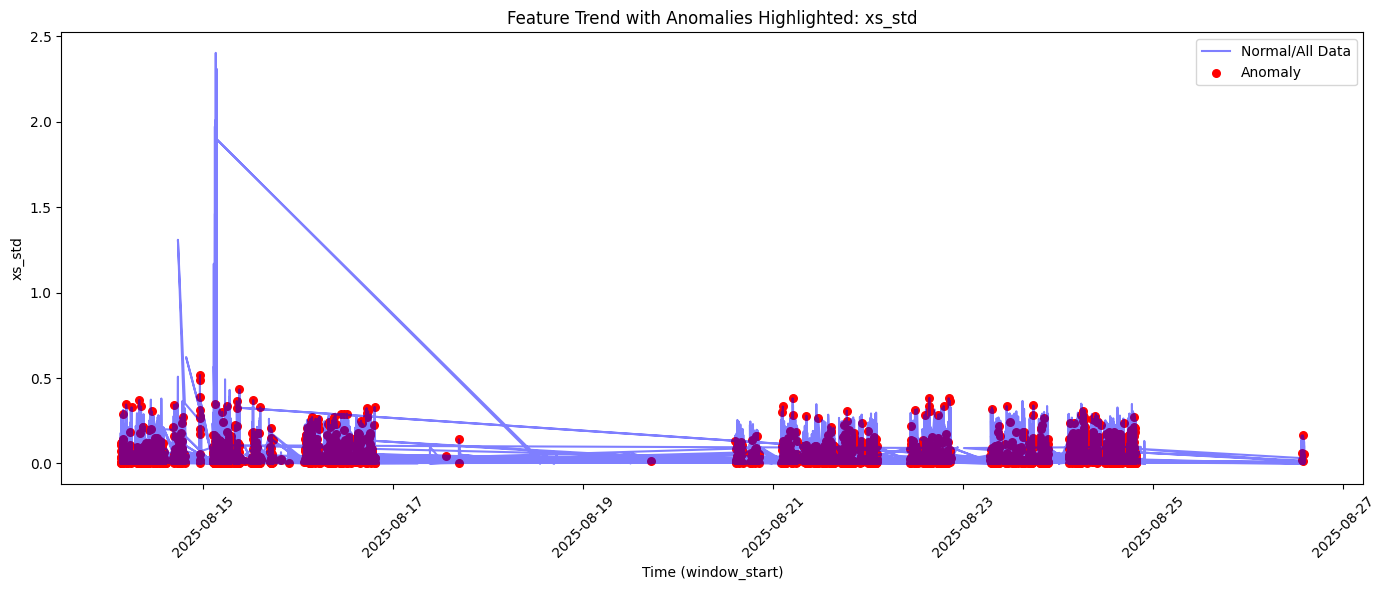

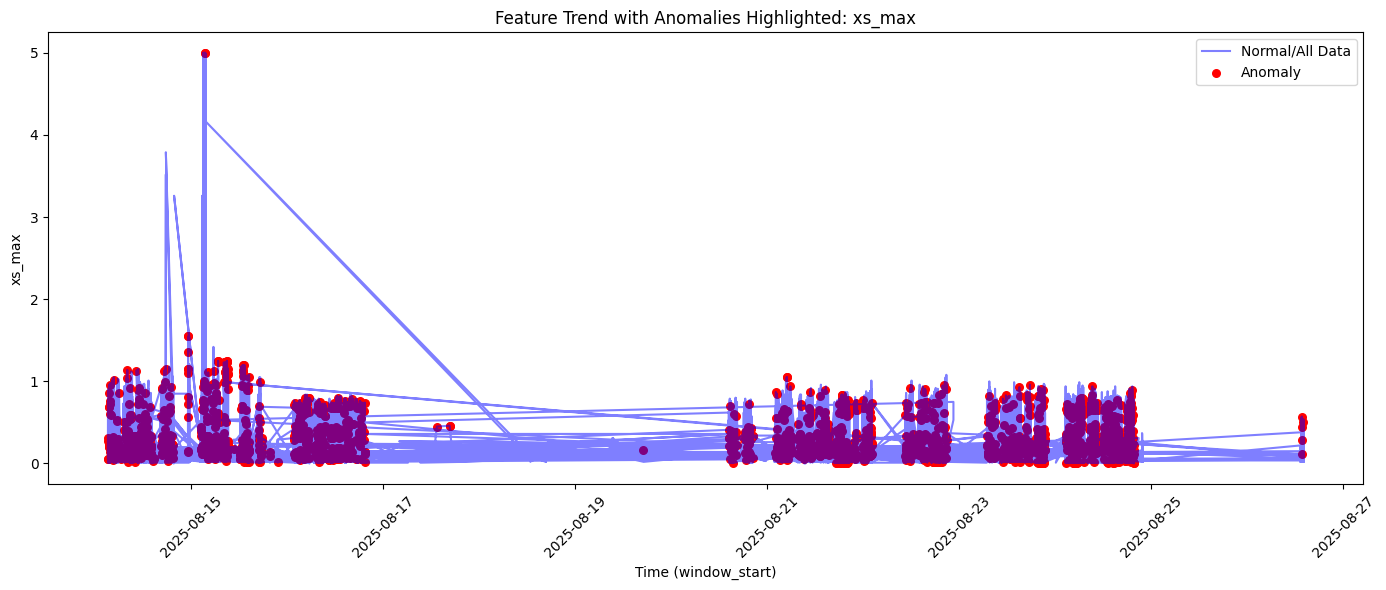

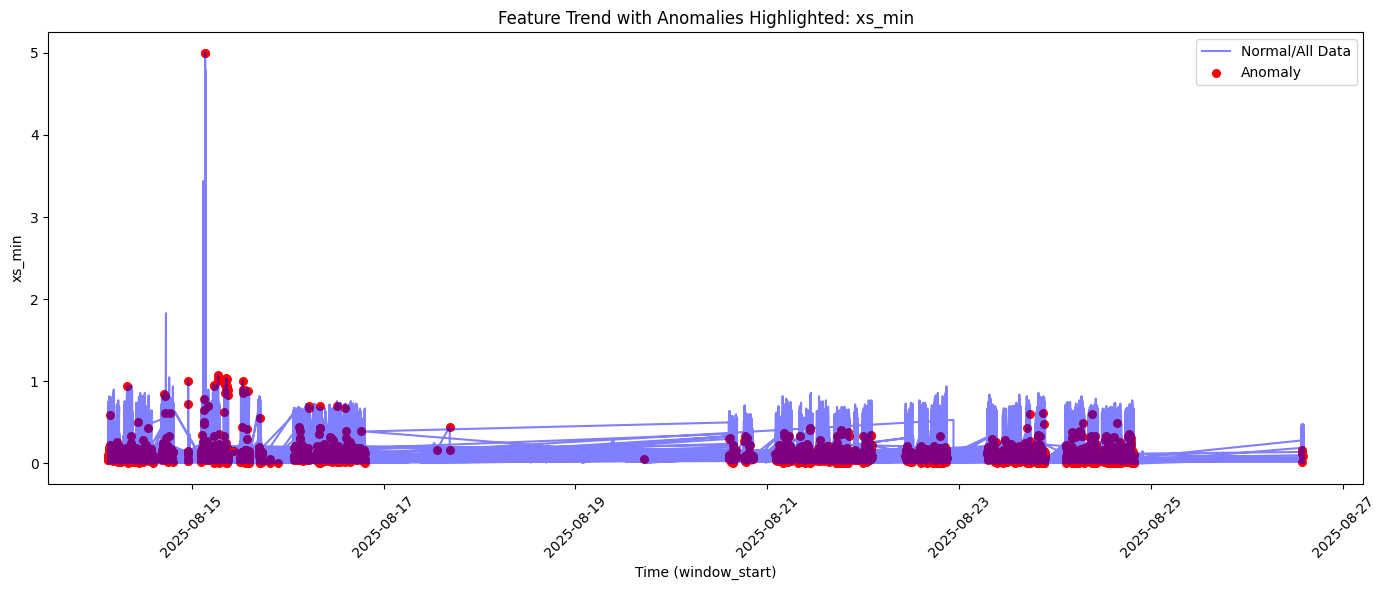

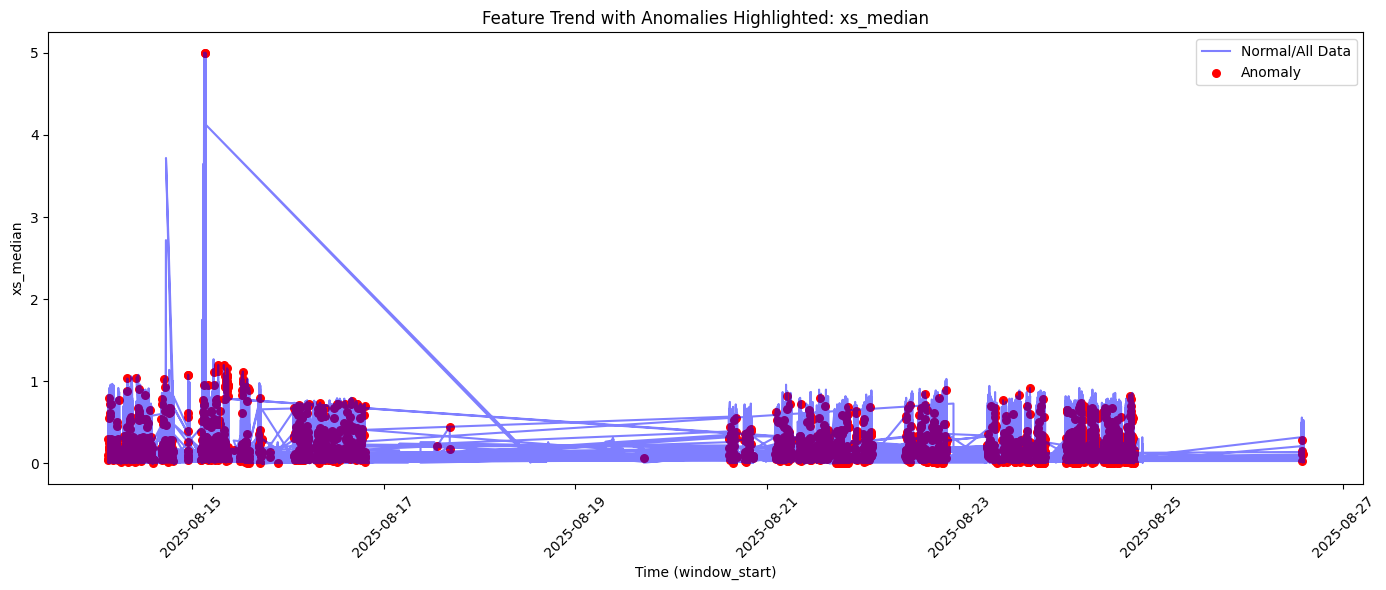

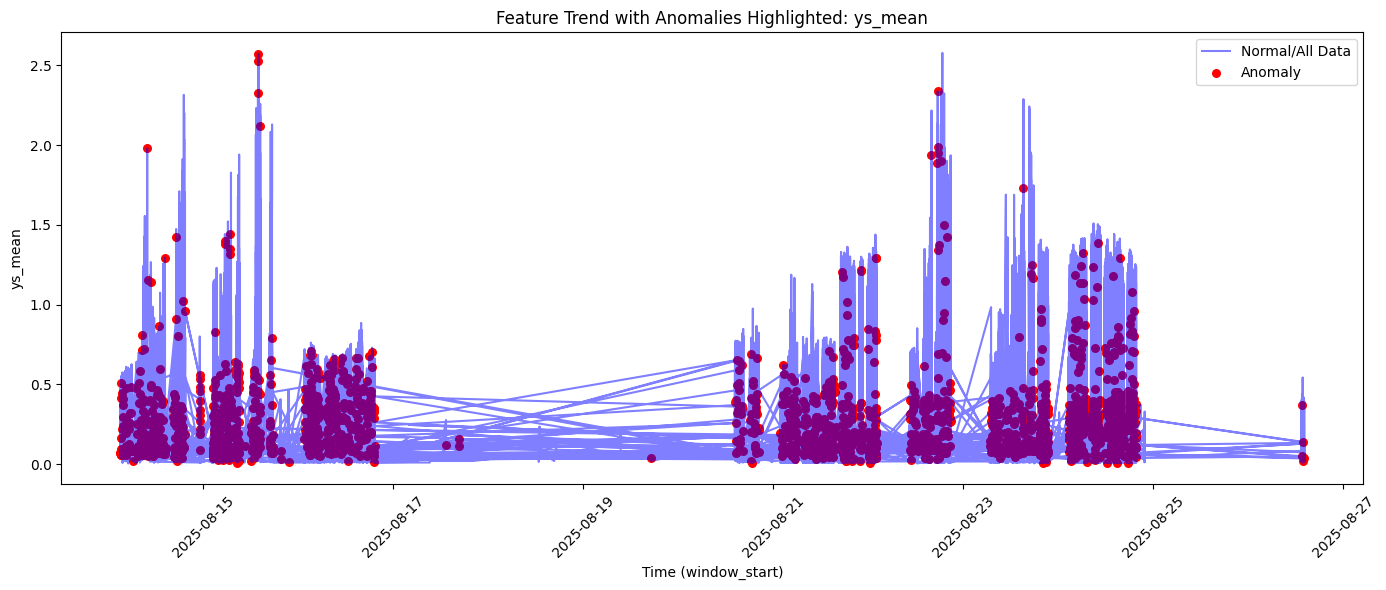

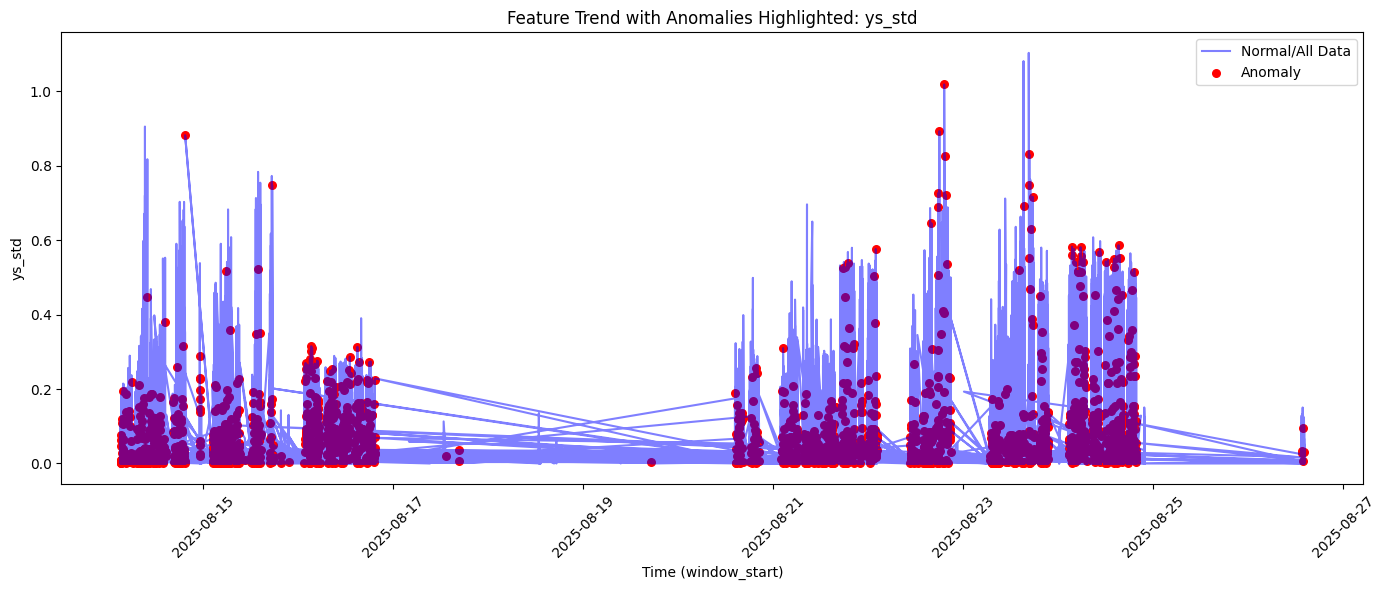

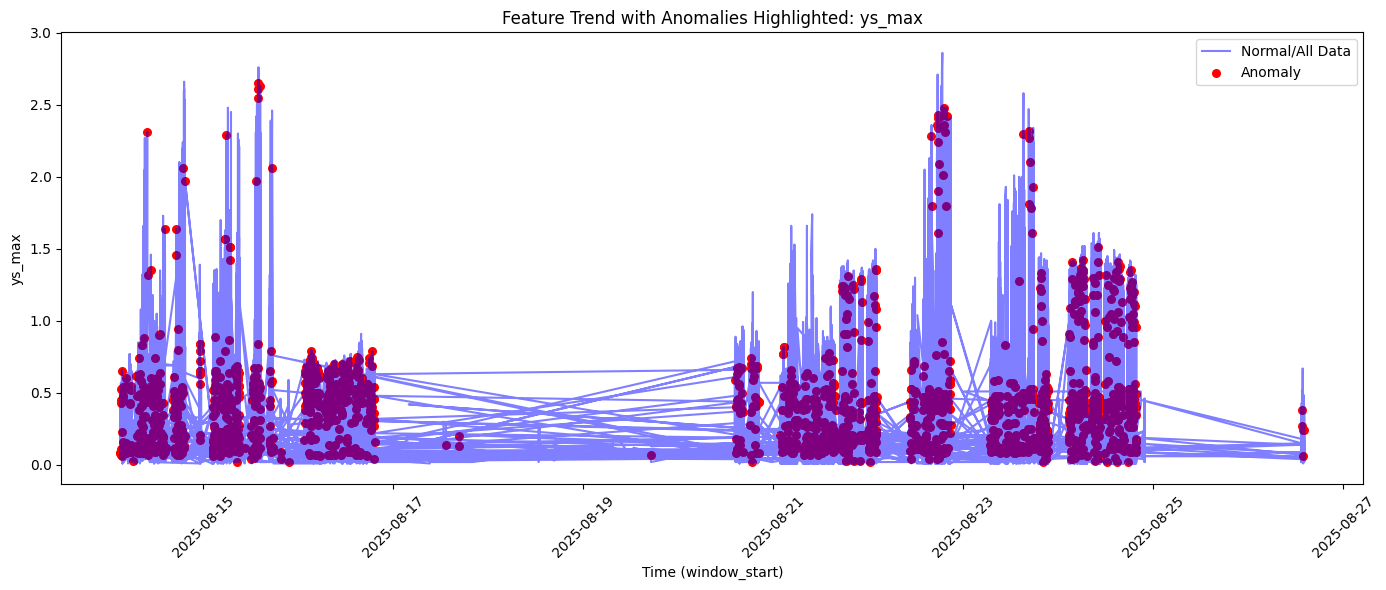

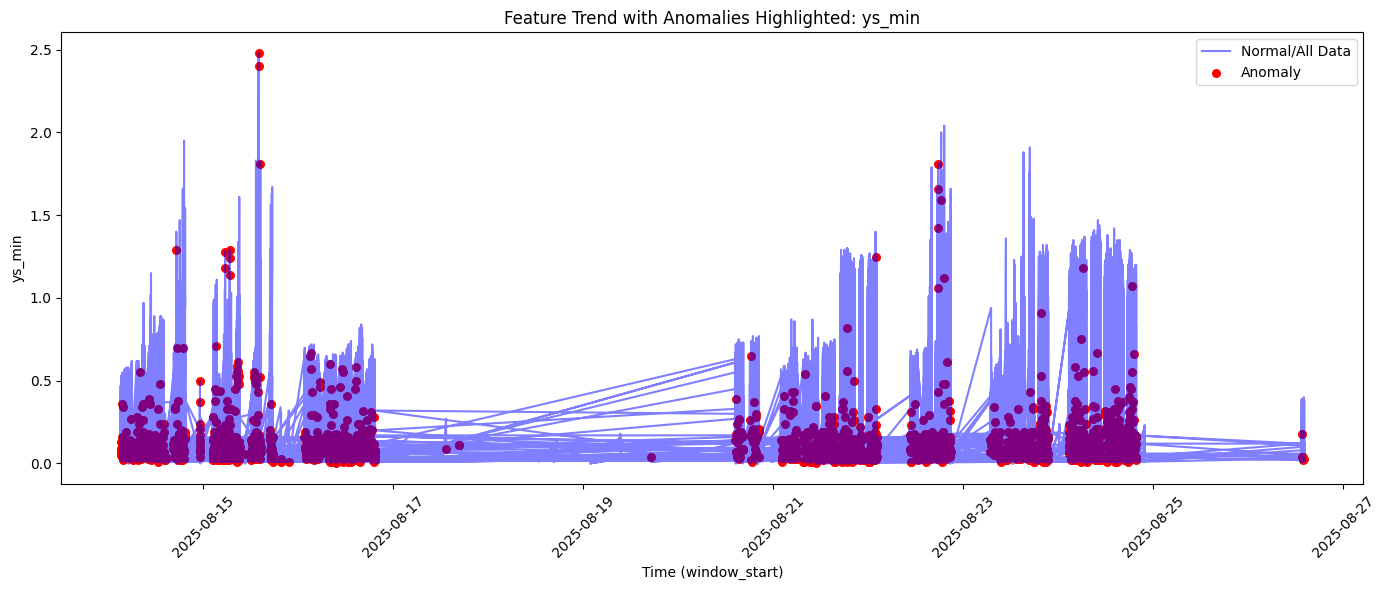

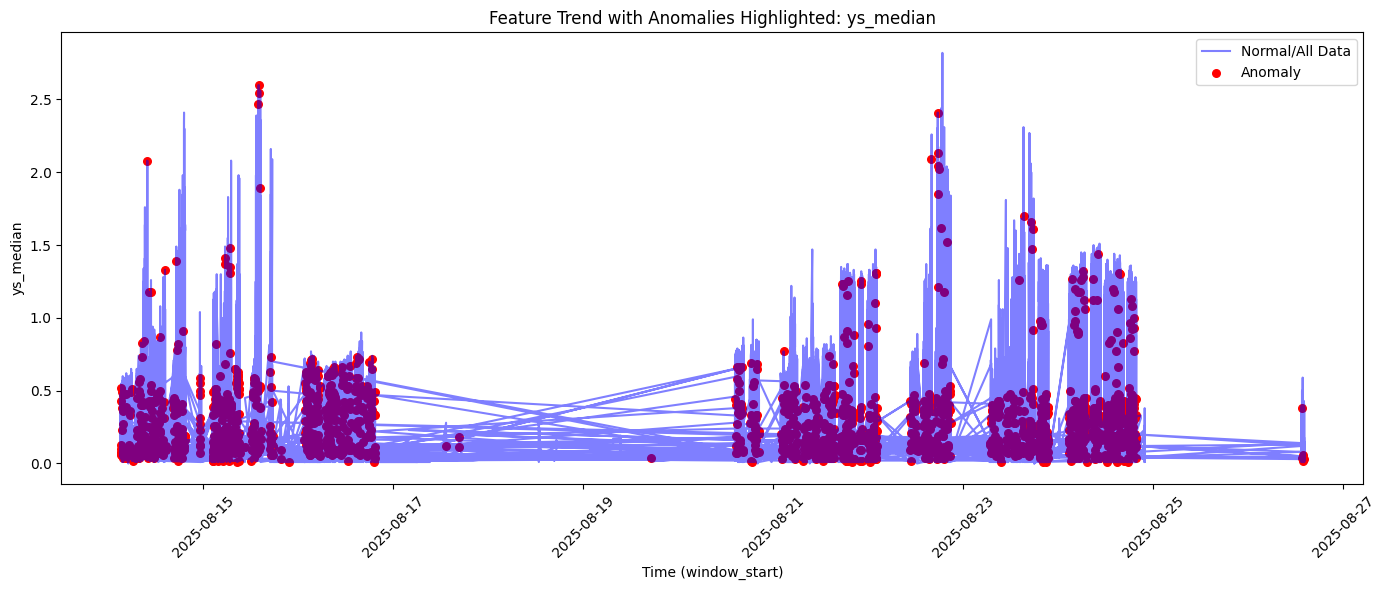

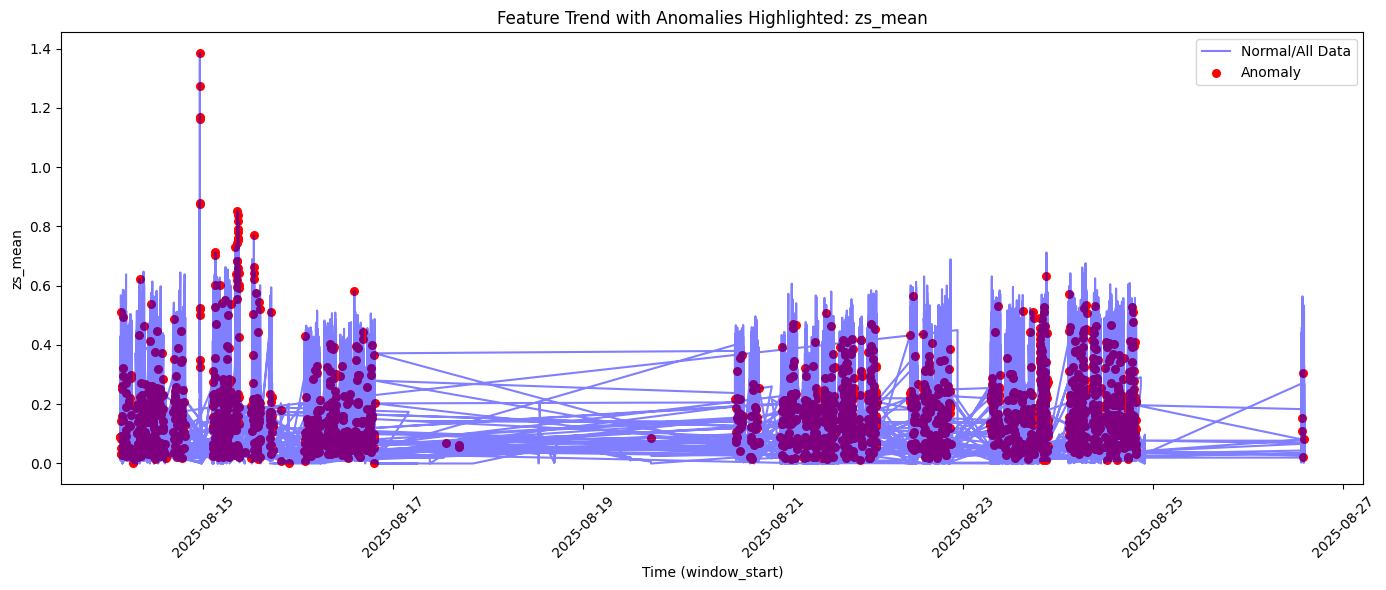

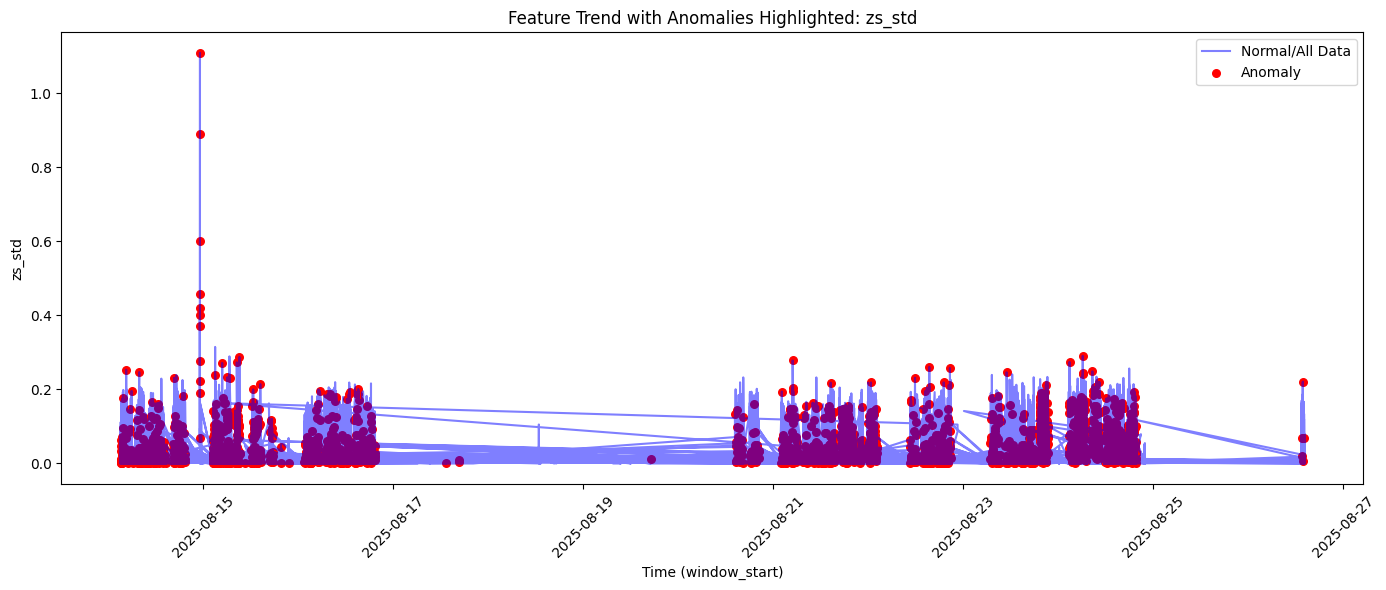

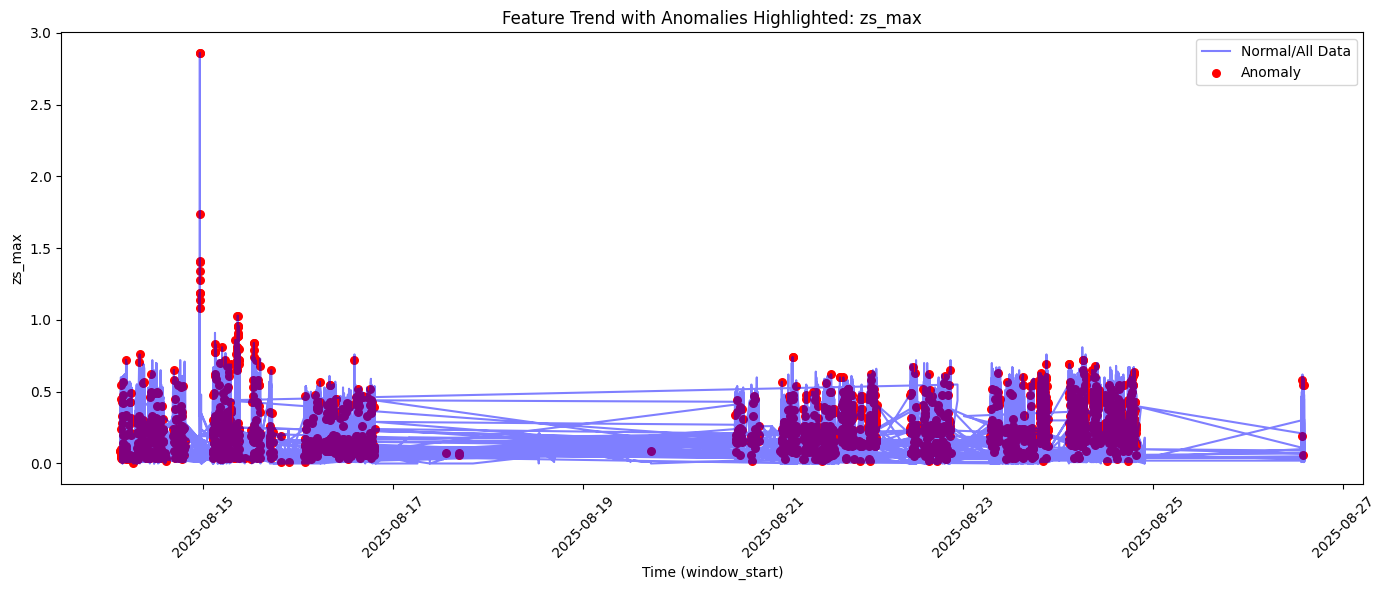

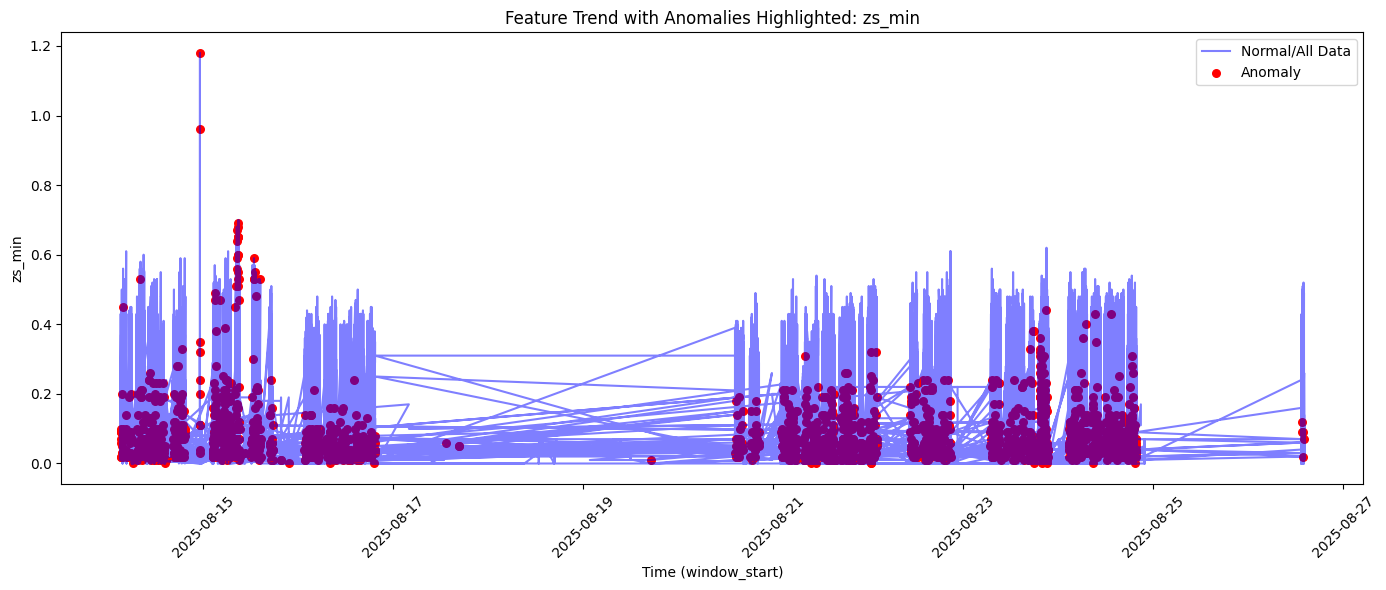

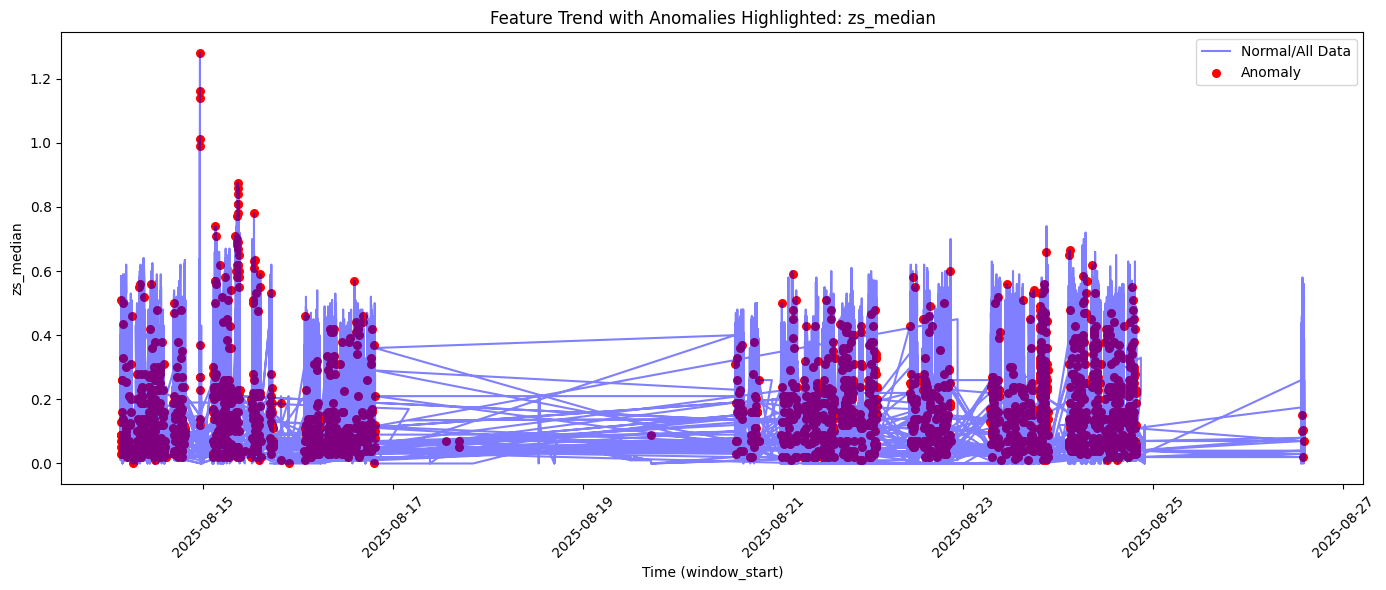

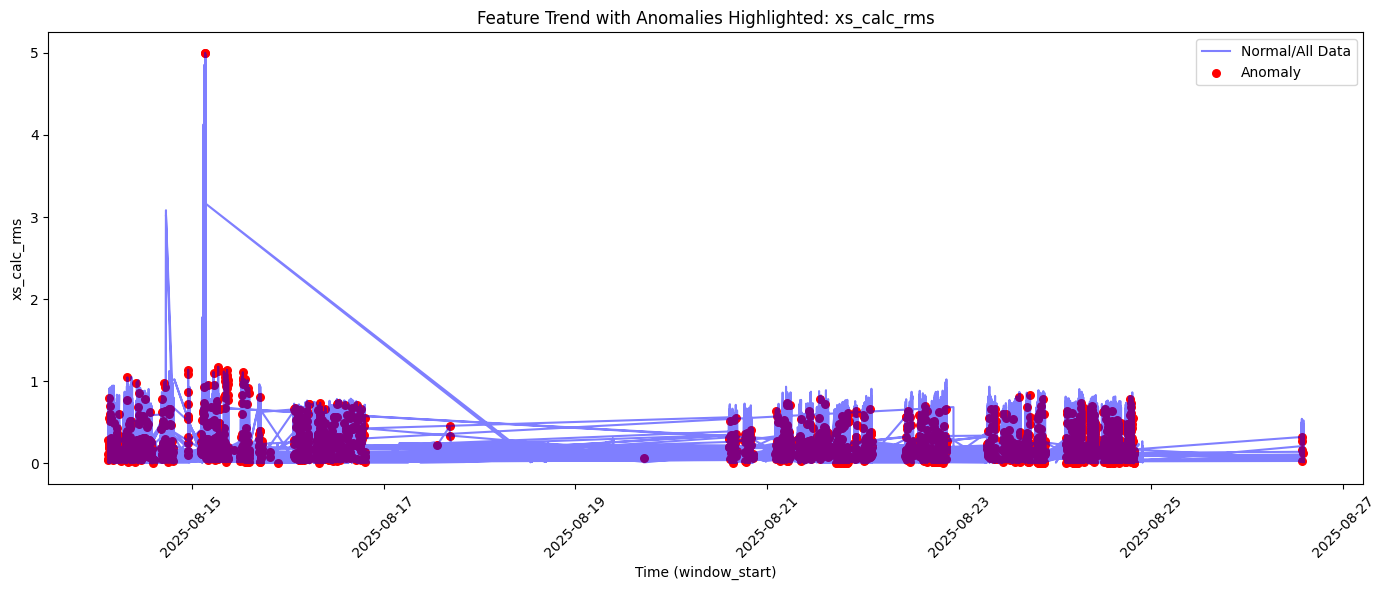

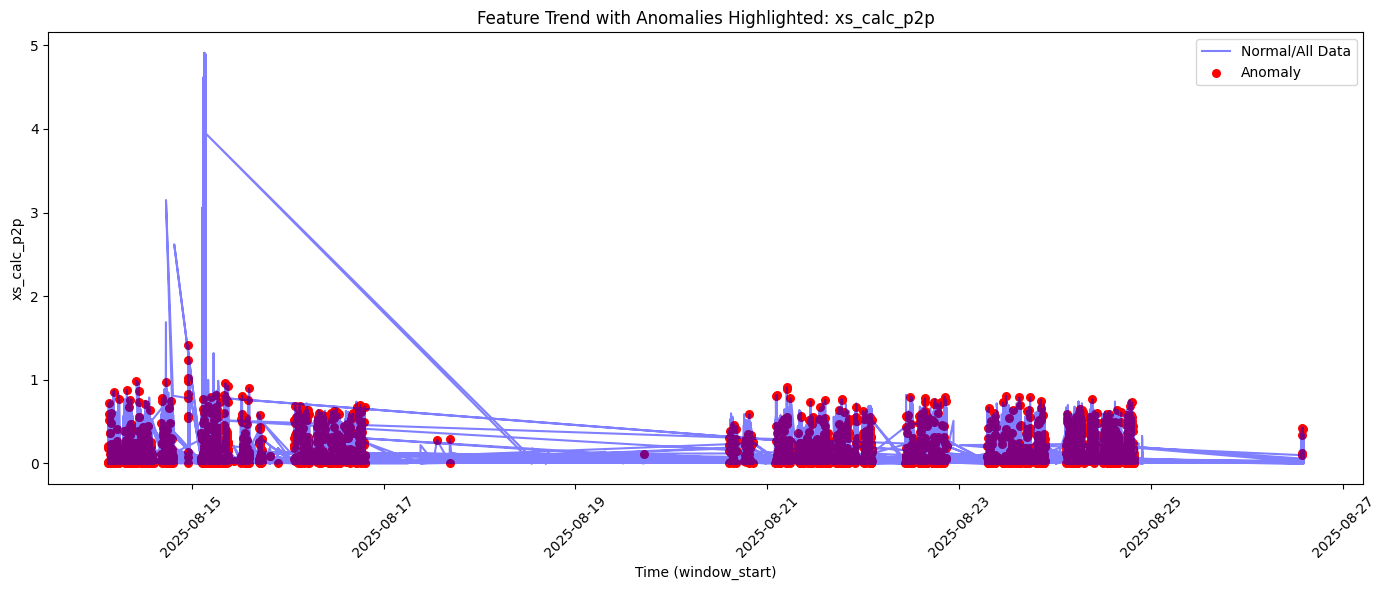

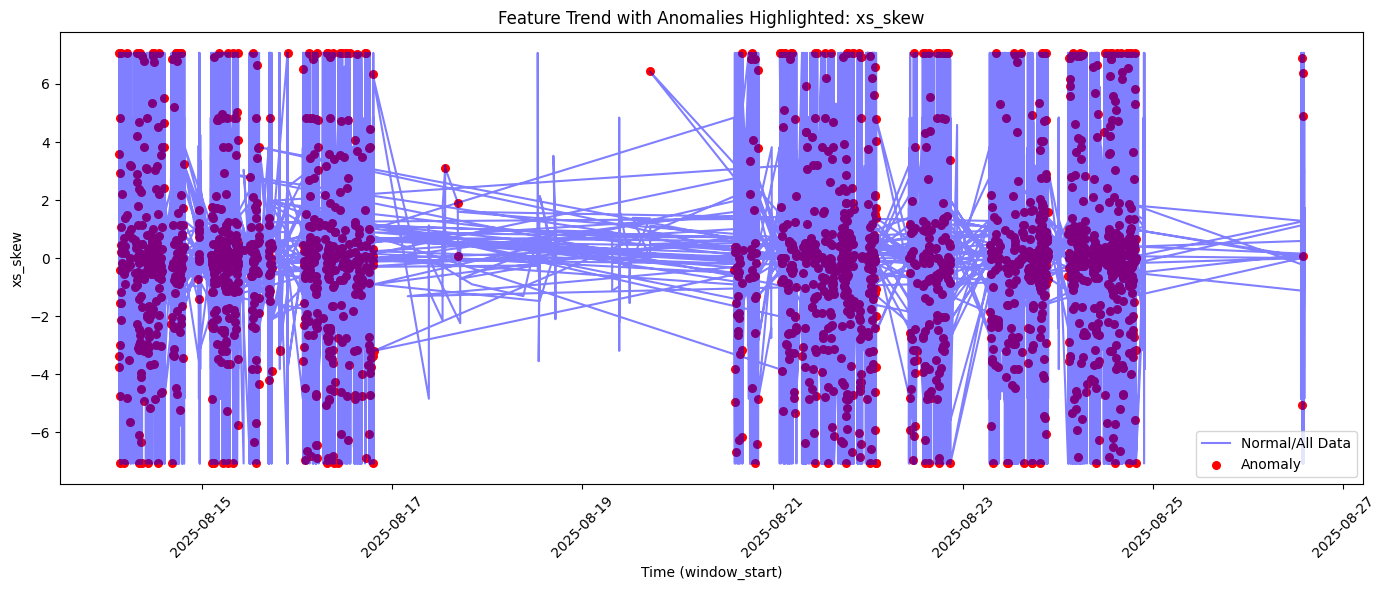

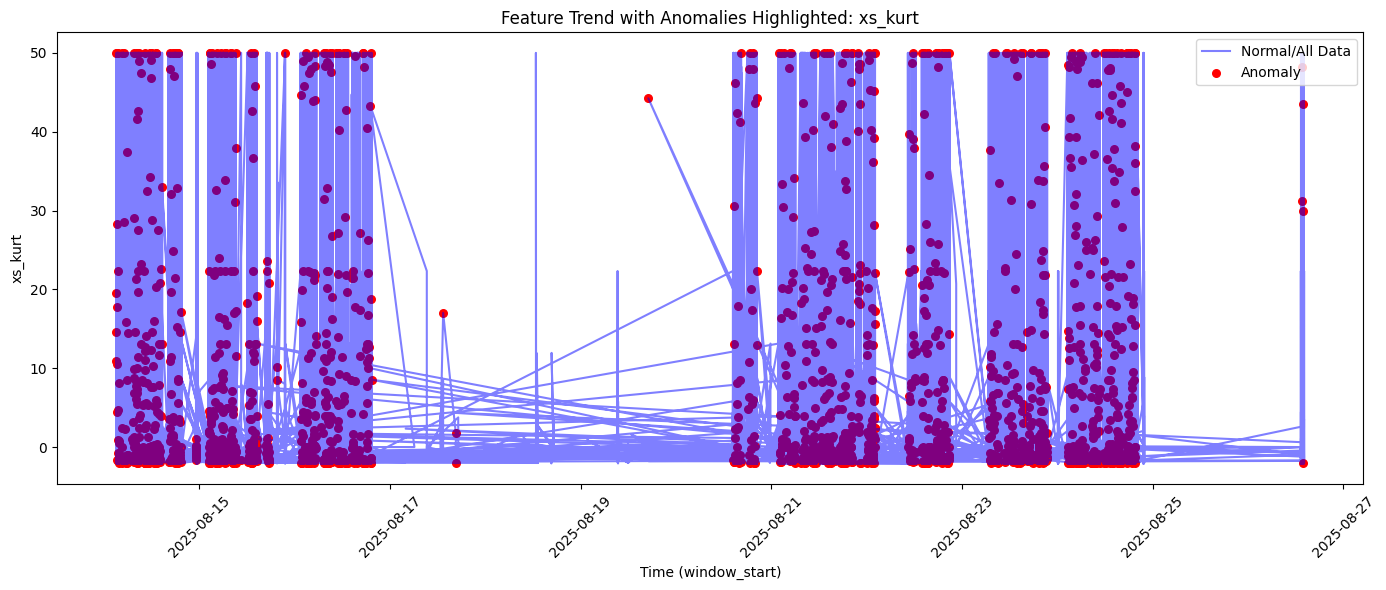

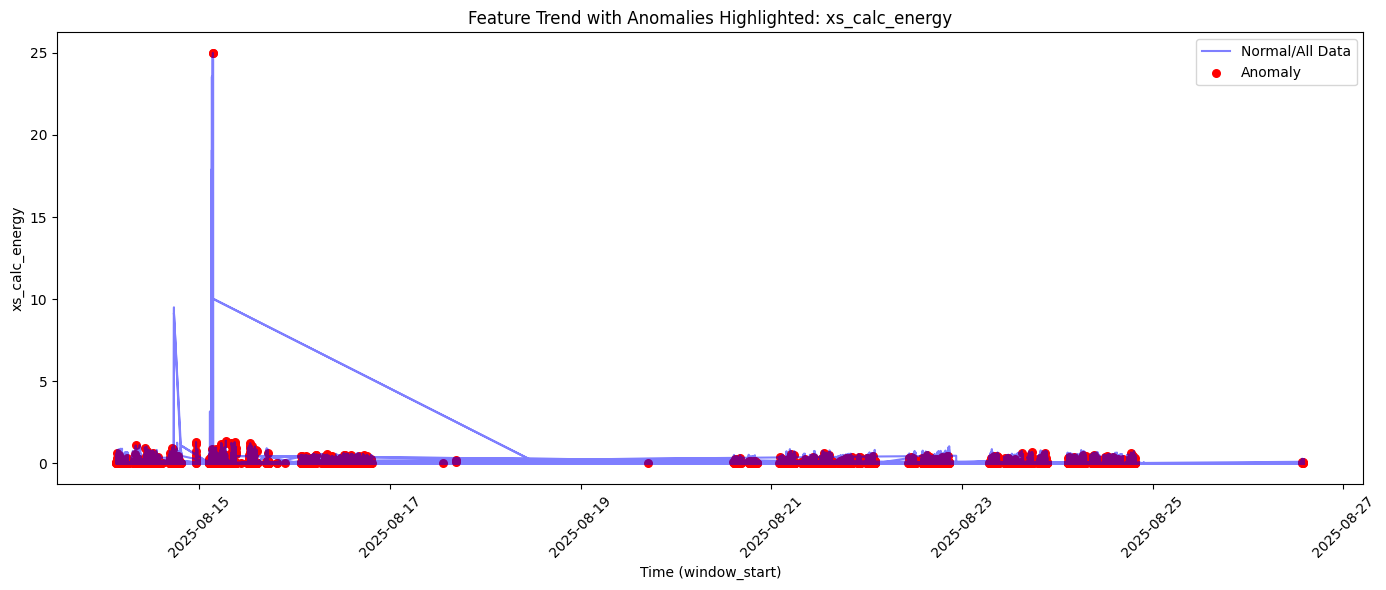

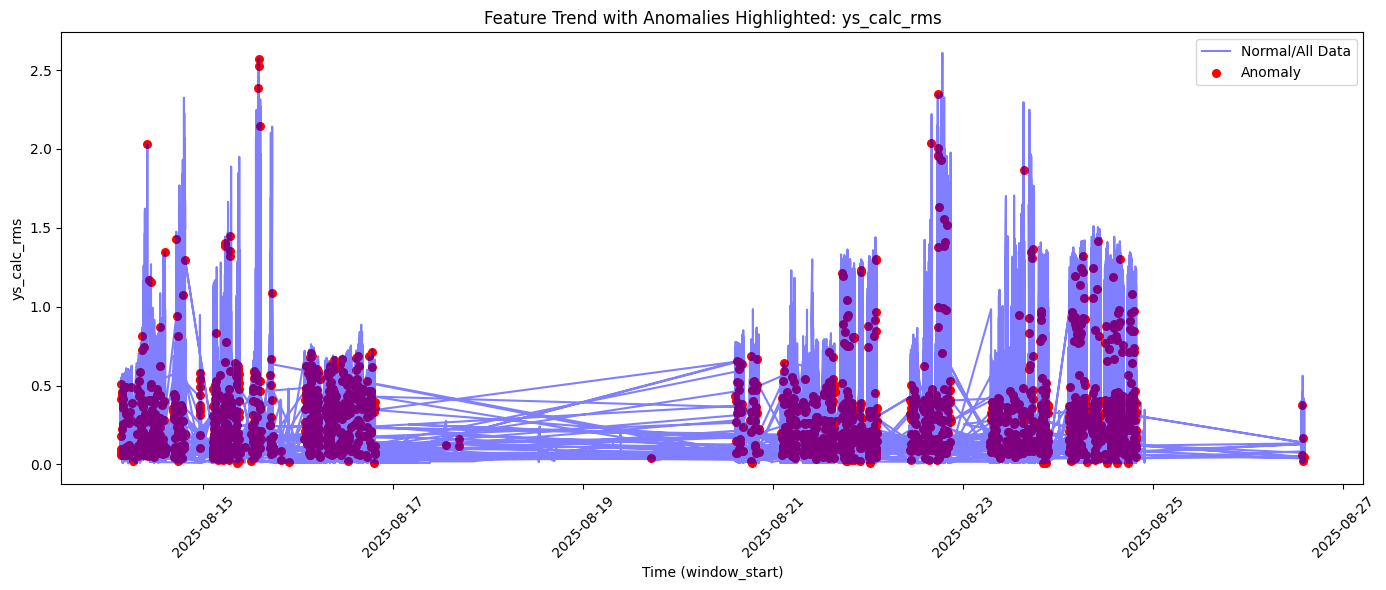

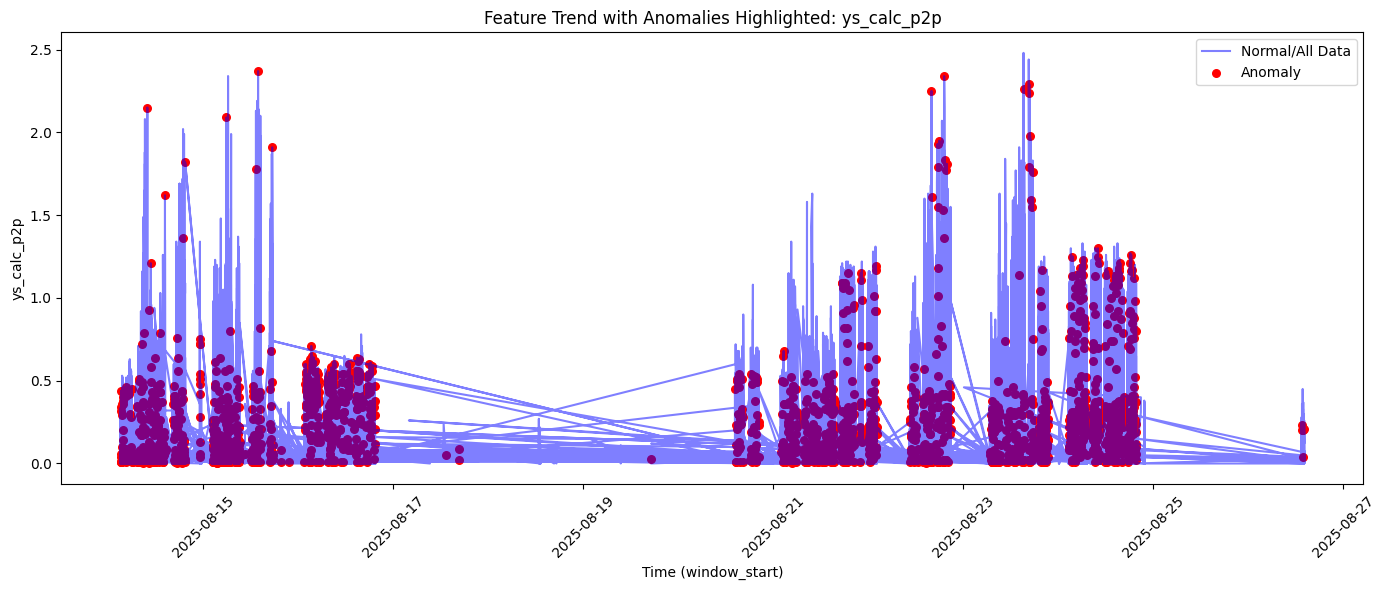

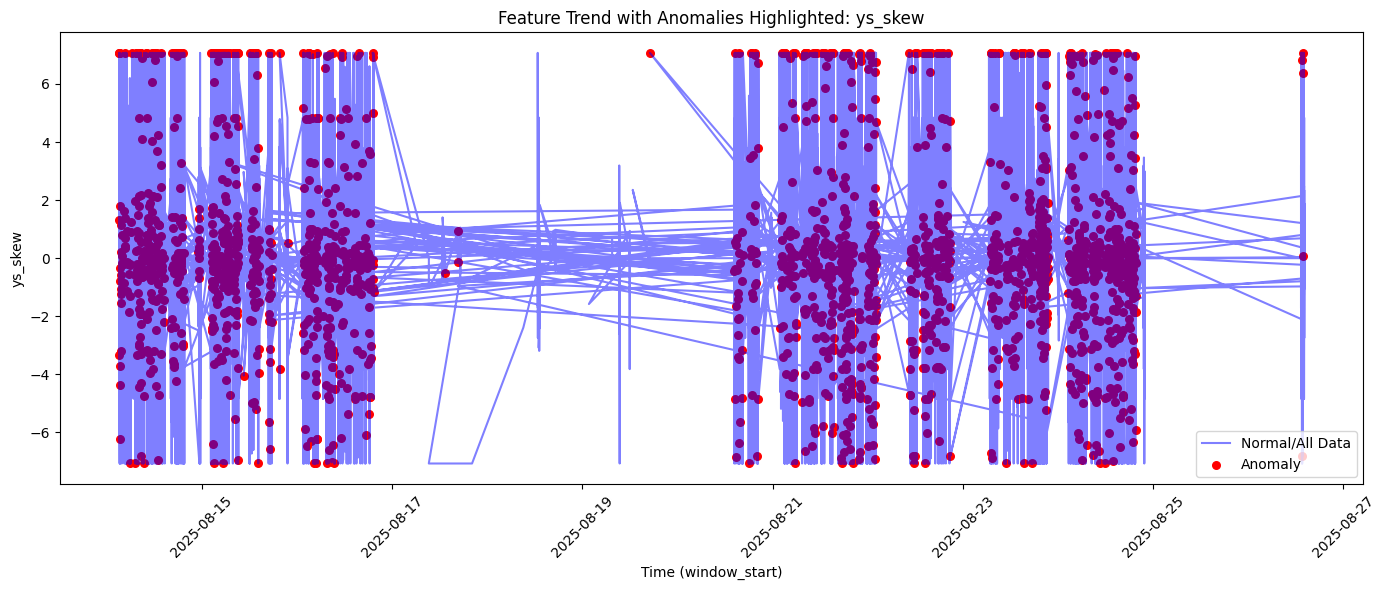

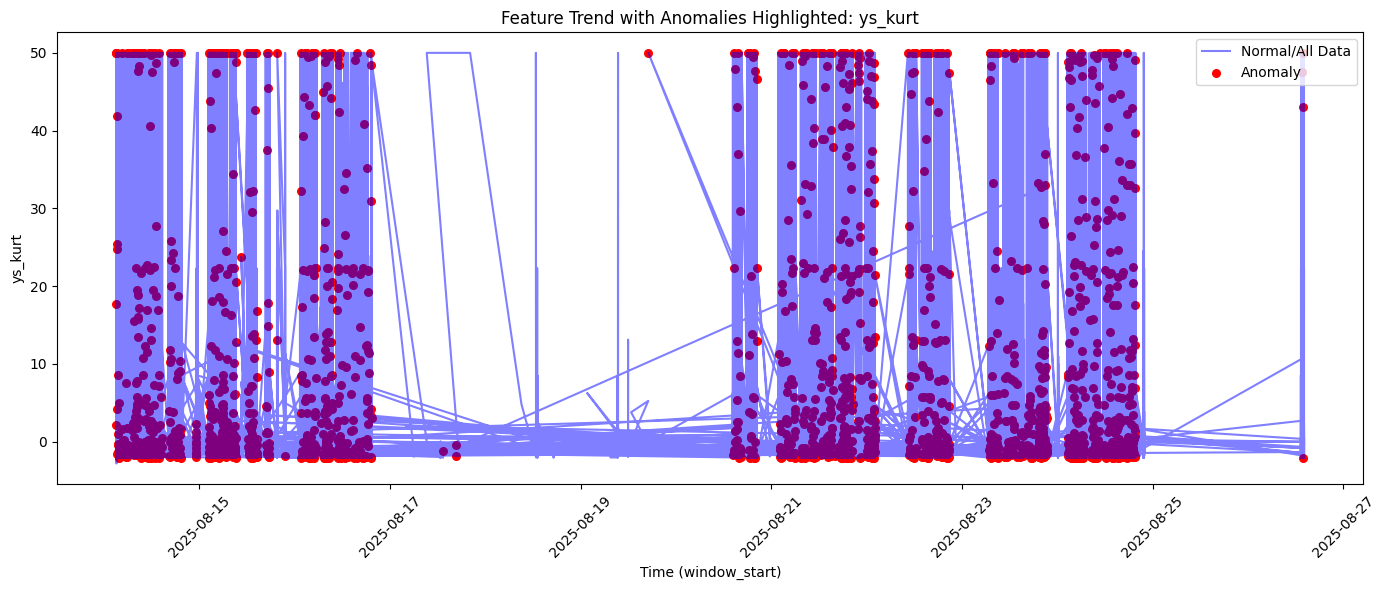

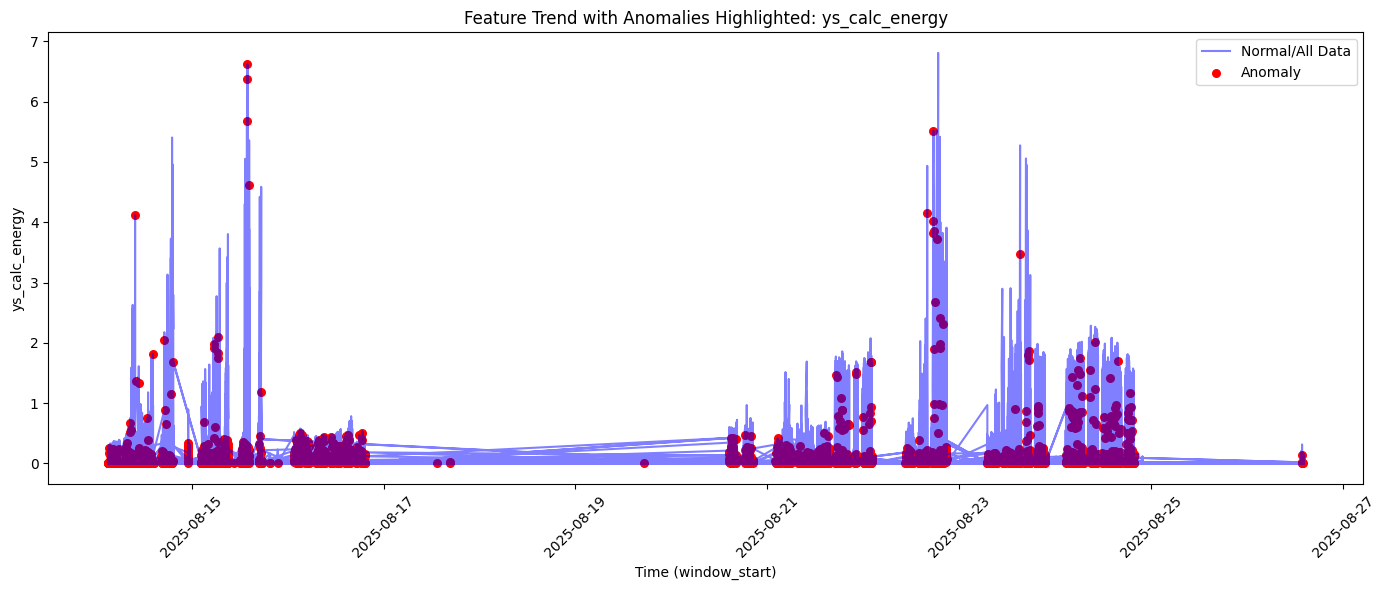

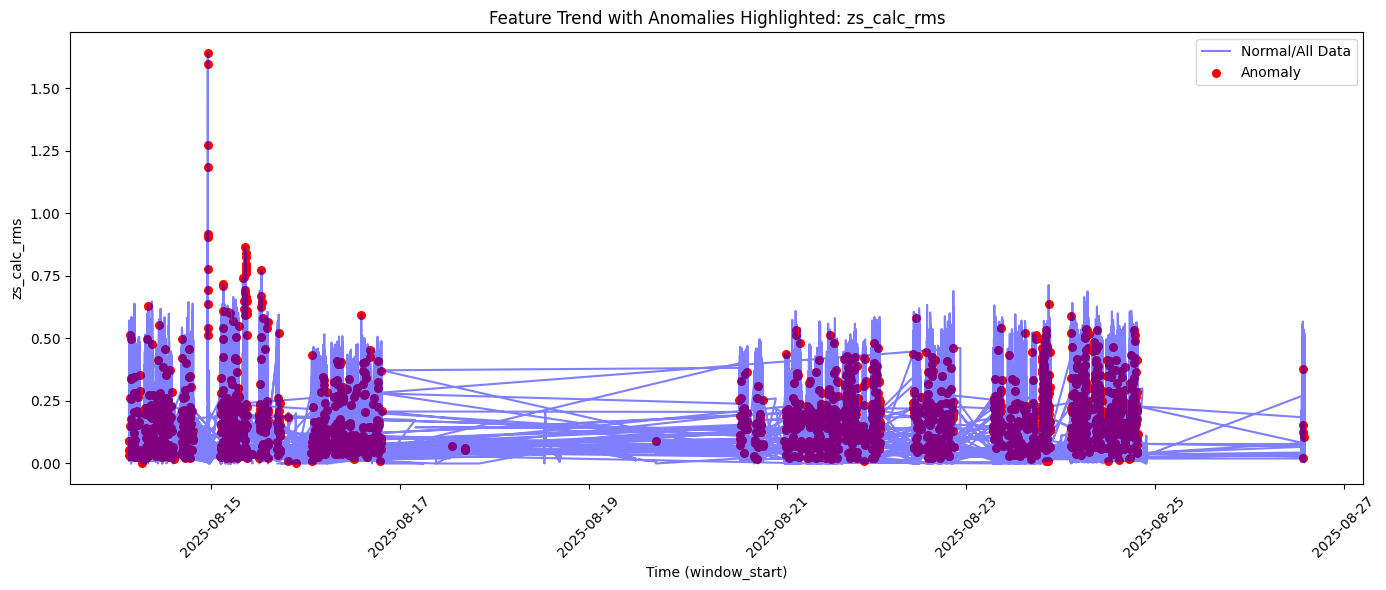

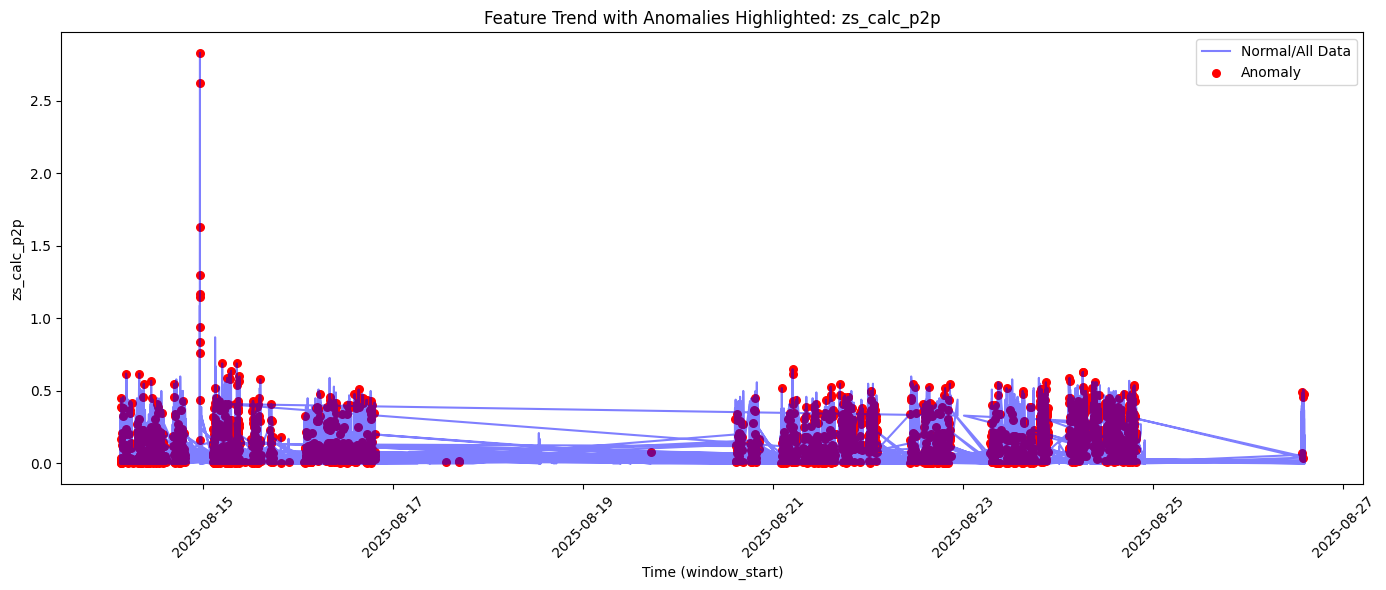

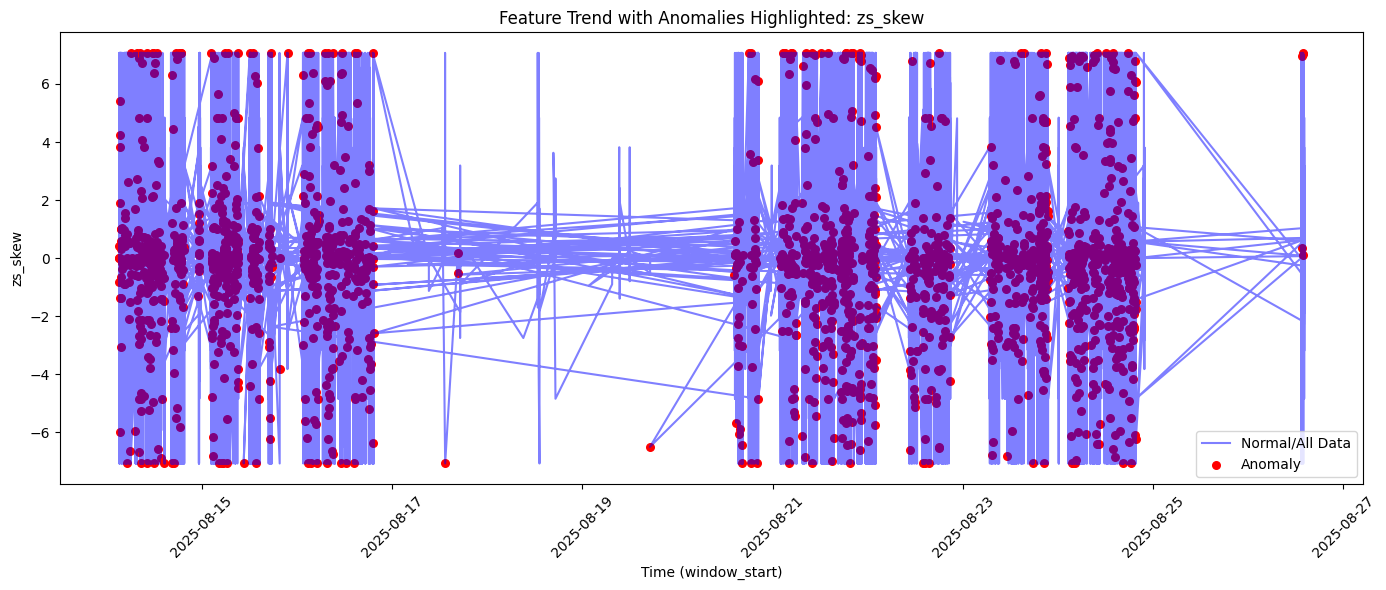

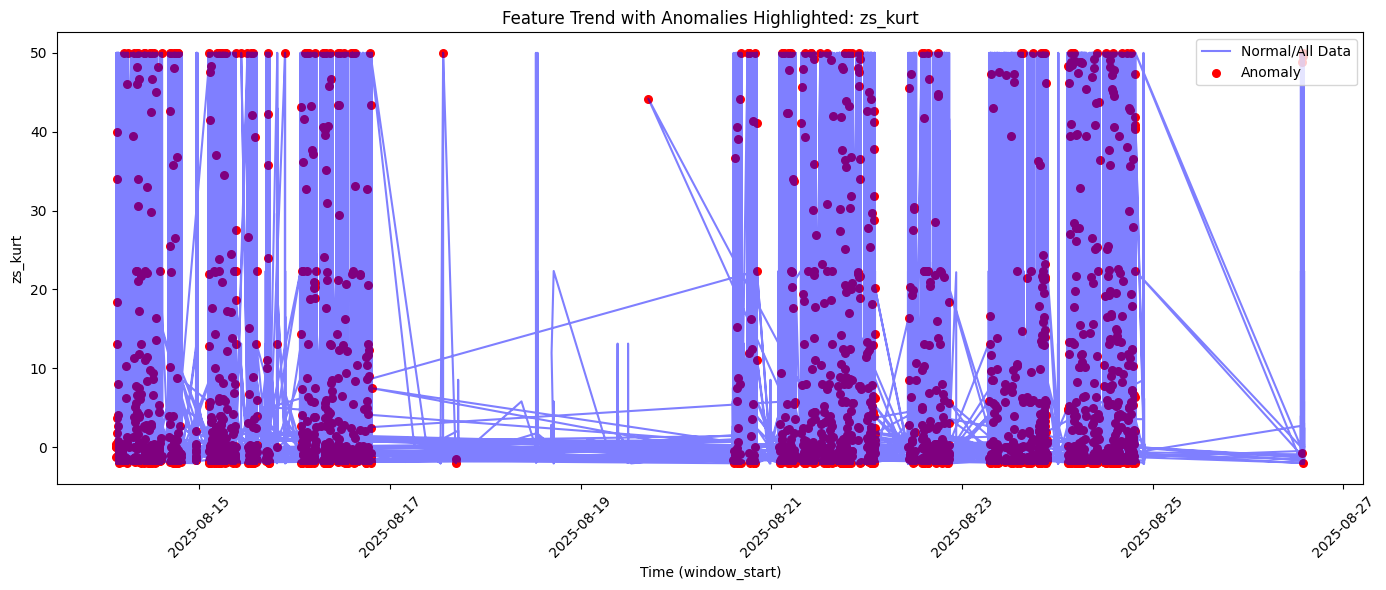

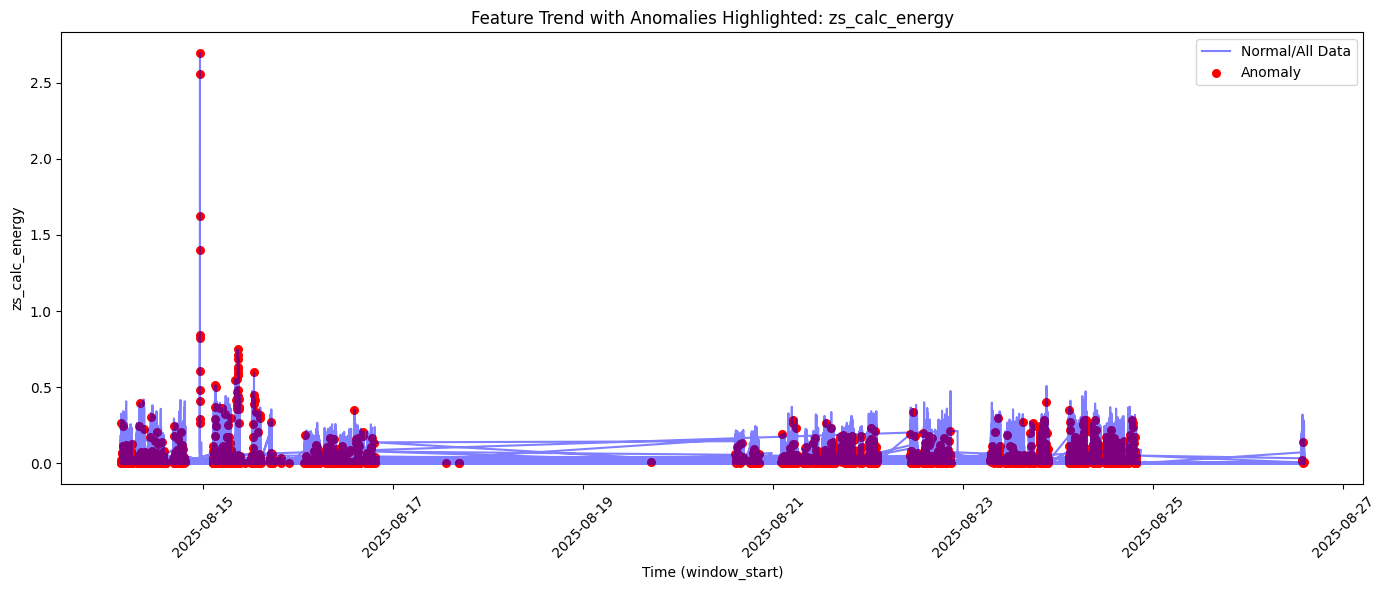

In [85]:
# Pick only feature columns (exclude IDs and time columns)
feature_cols = [c for c in df_plot.columns if c not in [
    'sensor_id','burst_id','window_index','window_start','window_end',
    'reconstruction_error','anomaly','threshold','anomaly_score'
]]

# Loop through each feature
for feature in feature_cols:
    plt.figure(figsize=(14, 6))

    # Plot feature values (blue line)
    plt.plot(
        df_plot['window_start'],
        df_plot[feature],
        c='blue',
        alpha=0.5,
        label="Normal/All Data"
    )

    # Overlay anomalies (red scatter)
    anomalies = df_plot[df_plot['anomaly'] == 1]
    plt.scatter(
        anomalies['window_start'],
        anomalies[feature],
        c='red',
        s=30,
        label="Anomaly"
    )

    plt.xlabel("Time (window_start)")
    plt.ylabel(feature)
    plt.title(f"Feature Trend with Anomalies Highlighted: {feature}")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


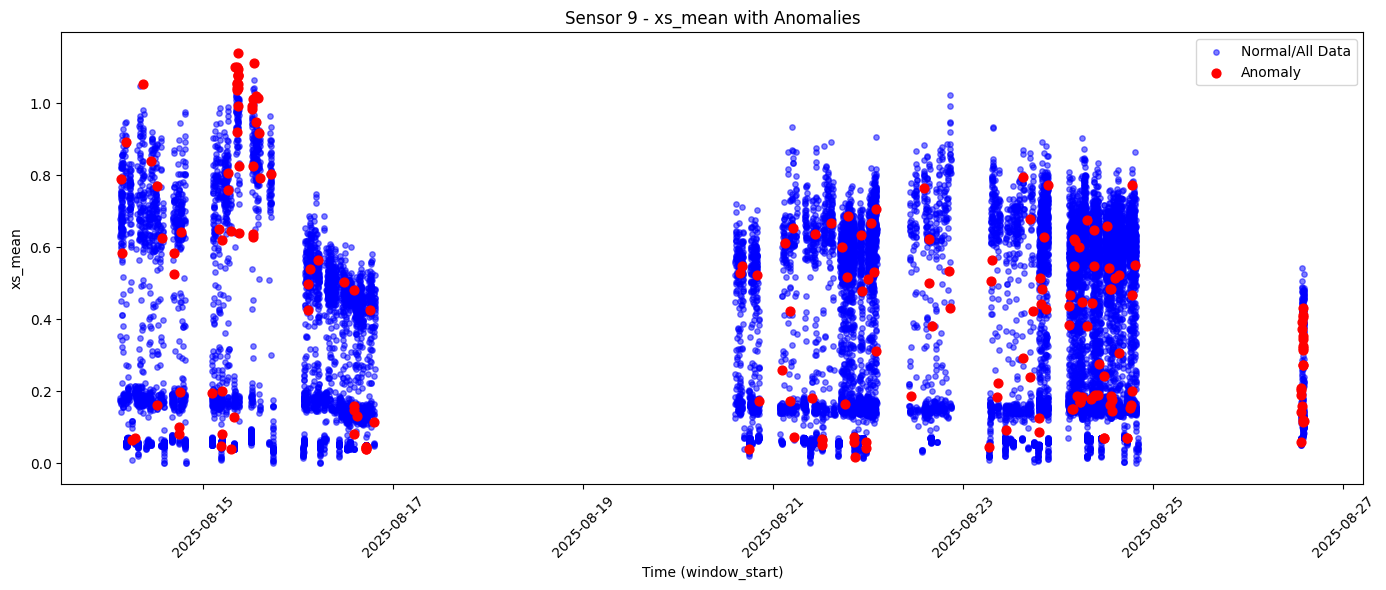

In [86]:
sensor_id_to_plot = 9
sensor_df = features_anomaly[features_anomaly['sensor_id'] == sensor_id_to_plot].copy()

# Choose one feature to visualize (example: xs_mean)
feature_to_plot = "xs_mean"

plt.figure(figsize=(14, 6))

# Plot all data points (blue scatter)
plt.scatter(
    sensor_df['window_start'],
    sensor_df[feature_to_plot],
    c='blue',
    alpha=0.5,
    s=15,
    label="Normal/All Data"
)

# Overlay anomalies (red scatter)
anomalies = sensor_df[sensor_df['anomaly'] == 1]
plt.scatter(
    anomalies['window_start'],
    anomalies[feature_to_plot],
    c='red',
    s=40,
    label="Anomaly"
)

plt.xlabel("Time (window_start)")
plt.ylabel(feature_to_plot)
plt.title(f"Sensor {sensor_id_to_plot} - {feature_to_plot} with Anomalies")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
